In [0]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [0]:
 (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

[[-1.         -1.         -1.         -1.         -1.         -0.99215686
  -1.         -1.         -1.         -1.         -0.67843137  0.4745098
  -0.19215686 -0.57647059 -0.62352941 -0.6627451  -0.31764706  0.31764706
   0.04313725 -0.8745098  -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -0.99215686 -1.         -1.
  -1.         -0.61568627  0.06666667  0.71764706  0.69411765  0.78823529
   0.85098039  1.          1.          1.          1.          0.70196078
   0.68627451  0.99215686  0.81176471  0.25490196 -0.64705882 -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -0.89019608
   0.38039216  0.74117647  0.75686275  0.6627451   0.59215686  0.55294118
   0.5372549   0.56862745  0.68627451  0.6         0.58431373  0.57647059
   0.57647059  0.57647059  0.63921569  0.70980392  0.75686275  0.28627451
  -1.         -1.         -1.      

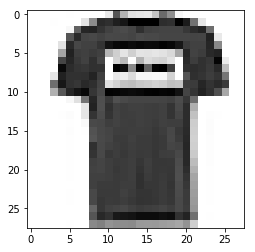

In [45]:
#Normalize
x_train = x_train/127.5-1


#Test
import matplotlib.pyplot as plt
plt.imshow(x_train[1], cmap='Greys')
print(x_train[1])
print(y_train[1])

In [0]:
#Deep learning packages
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU


# from __future__ import print_function, division

# from keras.datasets import fashion_mnist
# from keras.layers import Input, Dense, Reshape, Flatten, Dropout
# from keras.layers.convolutional import UpSampling2D, Conv2D
# from keras.models import Sequential, Model
# from keras.optimizers import Adam
# from keras.layers import BatchNormalization, Activation, ZeroPadding2D
# from keras.layers.advanced_activations import LeakyReLU

# import matplotlib.pyplot as plt
# import sys
# import numpy as np


x_train = np.expand_dims(x_train, axis=3)

In [70]:

def create_generator():
  model = Sequential()

  model.add(Dense(256, input_dim=100))
  model.add(LeakyReLU(0.3))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(512))
  model.add(LeakyReLU(0.3))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(1024))
  model.add(LeakyReLU(0.3))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(2048))
  model.add(LeakyReLU(0.3))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod((28, 28, 1)), activation='tanh'))
  model.add(Reshape((28, 28, 1)))

  model.summary()

  noise = Input(shape=(100,))
  img = model(noise)

  return Model(noise, img)

generator = create_generator()
z = Input(shape=(100,))
img = generator(z)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
dense_43 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 512)               2048      
_________________________________________________________________
dense_44 (Dense)             (None, 1024)            

In [72]:
def create_discriminator():
  model = Sequential()

  model.add(Flatten(input_shape=(28, 28, 1)))
  model.add(Dense(512))
  model.add(LeakyReLU(0.3))
  model.add(Dense(256))
  model.add(LeakyReLU(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=(28, 28, 1))
  validity = model(img)

  return Model(img, validity)

discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

In [0]:
validity = discriminator(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [0]:
def sample_images(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5*gen_imgs+0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1
  #fig.savefig("images/%d.png" % epoch)
  plt.show()
  plt.close()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.839340, acc.: 51.56%] [G loss: 0.780095]


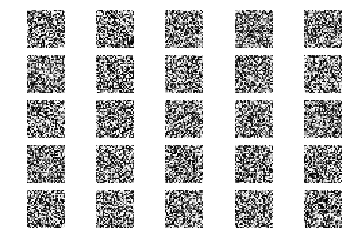

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.465633, acc.: 75.00%] [G loss: 0.789785]
2 [D loss: 0.352023, acc.: 75.00%] [G loss: 0.821701]
3 [D loss: 0.324927, acc.: 82.81%] [G loss: 0.840518]
4 [D loss: 0.312663, acc.: 82.81%] [G loss: 0.970416]
5 [D loss: 0.322098, acc.: 82.81%] [G loss: 1.056249]
6 [D loss: 0.247284, acc.: 92.19%] [G loss: 1.100538]
7 [D loss: 0.240129, acc.: 92.19%] [G loss: 1.209526]
8 [D loss: 0.234206, acc.: 92.19%] [G loss: 1.286434]
9 [D loss: 0.204212, acc.: 96.88%] [G loss: 1.374660]
10 [D loss: 0.252502, acc.: 93.75%] [G loss: 1.453175]
11 [D loss: 0.185331, acc.: 96.88%] [G loss: 1.553632]
12 [D loss: 0.152132, acc.: 100.00%] [G loss: 1.443190]
13 [D loss: 0.160752, acc.: 100.00%] [G loss: 1.594452]
14 [D loss: 0.145551, acc.: 100.00%] [G loss: 1.706893]
15 [D loss: 0.137506, acc.: 100.00%] [G loss: 1.751056]
16 [D loss: 0.117242, acc.: 100.00%] [G loss: 1.758720]
17 [D loss: 0.113020, acc.: 100.00%] [G loss: 1.916624]
18 [D loss: 0.117256, acc.: 100.00%] [G loss: 1.826419]
19 [D loss: 

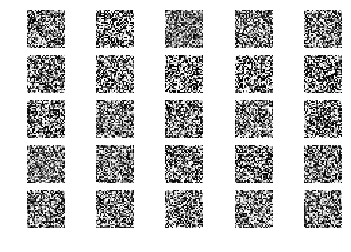

51 [D loss: 0.046747, acc.: 100.00%] [G loss: 3.397365]
52 [D loss: 0.027097, acc.: 100.00%] [G loss: 3.491377]
53 [D loss: 0.025025, acc.: 100.00%] [G loss: 3.529324]
54 [D loss: 0.033187, acc.: 100.00%] [G loss: 3.561798]
55 [D loss: 0.028390, acc.: 100.00%] [G loss: 3.594773]
56 [D loss: 0.022346, acc.: 100.00%] [G loss: 3.439056]
57 [D loss: 0.040125, acc.: 100.00%] [G loss: 3.616411]
58 [D loss: 0.048523, acc.: 100.00%] [G loss: 3.596909]
59 [D loss: 0.023433, acc.: 100.00%] [G loss: 3.582753]
60 [D loss: 0.024457, acc.: 100.00%] [G loss: 3.804544]
61 [D loss: 0.042132, acc.: 100.00%] [G loss: 3.864634]
62 [D loss: 0.026113, acc.: 100.00%] [G loss: 3.658632]
63 [D loss: 0.022628, acc.: 100.00%] [G loss: 3.743093]
64 [D loss: 0.024583, acc.: 100.00%] [G loss: 3.647727]
65 [D loss: 0.028073, acc.: 100.00%] [G loss: 3.666054]
66 [D loss: 0.013535, acc.: 100.00%] [G loss: 3.891987]
67 [D loss: 0.022018, acc.: 100.00%] [G loss: 3.960924]
68 [D loss: 0.027792, acc.: 100.00%] [G loss: 3.

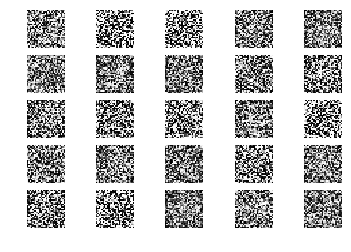

101 [D loss: 0.025750, acc.: 100.00%] [G loss: 4.573440]
102 [D loss: 0.011941, acc.: 100.00%] [G loss: 4.674547]
103 [D loss: 0.021234, acc.: 100.00%] [G loss: 4.470955]
104 [D loss: 0.019545, acc.: 100.00%] [G loss: 4.544297]
105 [D loss: 0.038946, acc.: 100.00%] [G loss: 4.593434]
106 [D loss: 0.037457, acc.: 98.44%] [G loss: 4.619076]
107 [D loss: 0.019850, acc.: 100.00%] [G loss: 4.383387]
108 [D loss: 0.038293, acc.: 100.00%] [G loss: 4.410304]
109 [D loss: 0.036035, acc.: 100.00%] [G loss: 4.514469]
110 [D loss: 0.030935, acc.: 100.00%] [G loss: 4.795886]
111 [D loss: 0.054650, acc.: 98.44%] [G loss: 4.520587]
112 [D loss: 0.044178, acc.: 100.00%] [G loss: 4.397714]
113 [D loss: 0.024115, acc.: 100.00%] [G loss: 4.608123]
114 [D loss: 0.033236, acc.: 98.44%] [G loss: 4.308992]
115 [D loss: 0.044181, acc.: 100.00%] [G loss: 4.663515]
116 [D loss: 0.031791, acc.: 100.00%] [G loss: 4.428711]
117 [D loss: 0.060708, acc.: 98.44%] [G loss: 4.736400]
118 [D loss: 0.034466, acc.: 100.00

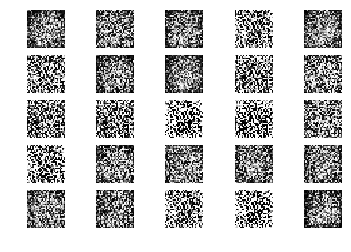

151 [D loss: 0.165612, acc.: 92.19%] [G loss: 3.960884]
152 [D loss: 0.179977, acc.: 93.75%] [G loss: 3.485585]
153 [D loss: 0.156584, acc.: 95.31%] [G loss: 4.113523]
154 [D loss: 0.175373, acc.: 90.62%] [G loss: 4.341832]
155 [D loss: 0.300749, acc.: 85.94%] [G loss: 4.124434]
156 [D loss: 0.139077, acc.: 96.88%] [G loss: 4.048412]
157 [D loss: 0.109723, acc.: 96.88%] [G loss: 4.112626]
158 [D loss: 0.320322, acc.: 82.81%] [G loss: 4.074282]
159 [D loss: 0.550218, acc.: 73.44%] [G loss: 3.744034]
160 [D loss: 0.130478, acc.: 90.62%] [G loss: 4.293934]
161 [D loss: 0.220384, acc.: 92.19%] [G loss: 4.296987]
162 [D loss: 0.100007, acc.: 96.88%] [G loss: 3.950490]
163 [D loss: 0.182661, acc.: 93.75%] [G loss: 3.474126]
164 [D loss: 0.245530, acc.: 90.62%] [G loss: 3.736370]
165 [D loss: 0.401455, acc.: 87.50%] [G loss: 2.745951]
166 [D loss: 0.277307, acc.: 87.50%] [G loss: 3.476885]
167 [D loss: 0.185811, acc.: 92.19%] [G loss: 3.308242]
168 [D loss: 0.136906, acc.: 93.75%] [G loss: 4.

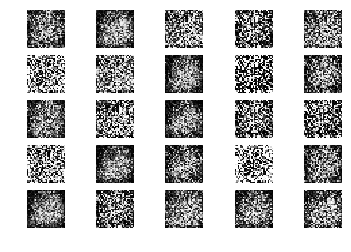

201 [D loss: 0.559228, acc.: 71.88%] [G loss: 2.676788]
202 [D loss: 0.356397, acc.: 82.81%] [G loss: 2.970954]
203 [D loss: 0.133965, acc.: 98.44%] [G loss: 2.841416]
204 [D loss: 0.134354, acc.: 96.88%] [G loss: 2.973453]
205 [D loss: 0.495041, acc.: 75.00%] [G loss: 3.226768]
206 [D loss: 0.311569, acc.: 87.50%] [G loss: 3.113816]
207 [D loss: 0.320658, acc.: 85.94%] [G loss: 3.192260]
208 [D loss: 0.314671, acc.: 82.81%] [G loss: 3.189919]
209 [D loss: 0.284498, acc.: 87.50%] [G loss: 2.954312]
210 [D loss: 0.140466, acc.: 96.88%] [G loss: 3.207459]
211 [D loss: 0.245443, acc.: 93.75%] [G loss: 2.838377]
212 [D loss: 0.325739, acc.: 81.25%] [G loss: 3.387475]
213 [D loss: 0.273519, acc.: 89.06%] [G loss: 3.746278]
214 [D loss: 0.137443, acc.: 96.88%] [G loss: 3.246934]
215 [D loss: 0.427117, acc.: 76.56%] [G loss: 2.955050]
216 [D loss: 0.208371, acc.: 90.62%] [G loss: 3.423084]
217 [D loss: 0.171250, acc.: 95.31%] [G loss: 2.760149]
218 [D loss: 0.249874, acc.: 85.94%] [G loss: 3.

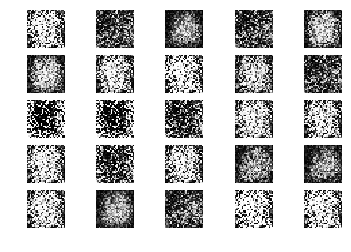

251 [D loss: 0.236616, acc.: 89.06%] [G loss: 3.379674]
252 [D loss: 0.249434, acc.: 93.75%] [G loss: 2.978819]
253 [D loss: 0.215995, acc.: 93.75%] [G loss: 3.072359]
254 [D loss: 0.381677, acc.: 78.12%] [G loss: 3.258316]
255 [D loss: 0.237127, acc.: 89.06%] [G loss: 3.224377]
256 [D loss: 0.446810, acc.: 79.69%] [G loss: 3.260900]
257 [D loss: 0.431310, acc.: 79.69%] [G loss: 2.718472]
258 [D loss: 0.271412, acc.: 90.62%] [G loss: 3.455185]
259 [D loss: 0.356718, acc.: 84.38%] [G loss: 3.610981]
260 [D loss: 0.452100, acc.: 78.12%] [G loss: 3.031186]
261 [D loss: 0.551712, acc.: 68.75%] [G loss: 2.551598]
262 [D loss: 0.347378, acc.: 84.38%] [G loss: 3.539562]
263 [D loss: 0.270167, acc.: 92.19%] [G loss: 3.289124]
264 [D loss: 0.206388, acc.: 92.19%] [G loss: 2.848765]
265 [D loss: 0.377264, acc.: 76.56%] [G loss: 2.440436]
266 [D loss: 0.448424, acc.: 73.44%] [G loss: 3.429034]
267 [D loss: 0.595330, acc.: 65.62%] [G loss: 2.794242]
268 [D loss: 0.335071, acc.: 76.56%] [G loss: 3.

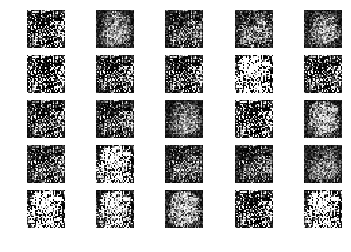

301 [D loss: 0.303294, acc.: 87.50%] [G loss: 2.761167]
302 [D loss: 0.398193, acc.: 81.25%] [G loss: 2.622970]
303 [D loss: 0.204382, acc.: 90.62%] [G loss: 3.170100]
304 [D loss: 0.240415, acc.: 90.62%] [G loss: 2.653843]
305 [D loss: 0.249445, acc.: 90.62%] [G loss: 2.993462]
306 [D loss: 0.351371, acc.: 84.38%] [G loss: 3.112379]
307 [D loss: 0.415323, acc.: 81.25%] [G loss: 5.002333]
308 [D loss: 0.309779, acc.: 85.94%] [G loss: 3.330719]
309 [D loss: 0.186367, acc.: 90.62%] [G loss: 3.170272]
310 [D loss: 0.177745, acc.: 92.19%] [G loss: 2.895130]
311 [D loss: 0.322080, acc.: 82.81%] [G loss: 3.568298]
312 [D loss: 0.245204, acc.: 93.75%] [G loss: 3.091423]
313 [D loss: 0.237844, acc.: 93.75%] [G loss: 3.199393]
314 [D loss: 0.322750, acc.: 89.06%] [G loss: 3.070472]
315 [D loss: 0.360123, acc.: 90.62%] [G loss: 2.340467]
316 [D loss: 0.205380, acc.: 90.62%] [G loss: 3.075387]
317 [D loss: 0.324503, acc.: 87.50%] [G loss: 3.343809]
318 [D loss: 0.396165, acc.: 78.12%] [G loss: 2.

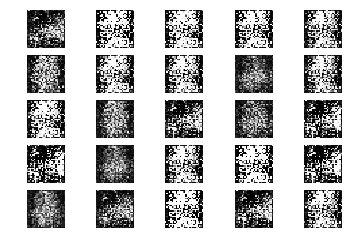

351 [D loss: 0.370186, acc.: 82.81%] [G loss: 3.108439]
352 [D loss: 0.206039, acc.: 98.44%] [G loss: 3.273252]
353 [D loss: 0.474137, acc.: 76.56%] [G loss: 2.116609]
354 [D loss: 0.350137, acc.: 82.81%] [G loss: 2.767195]
355 [D loss: 0.258061, acc.: 92.19%] [G loss: 3.352849]
356 [D loss: 0.343917, acc.: 84.38%] [G loss: 2.417050]
357 [D loss: 0.313273, acc.: 87.50%] [G loss: 2.891577]
358 [D loss: 0.316287, acc.: 85.94%] [G loss: 3.479929]
359 [D loss: 0.377420, acc.: 82.81%] [G loss: 2.793489]
360 [D loss: 0.278393, acc.: 90.62%] [G loss: 3.371882]
361 [D loss: 0.263723, acc.: 89.06%] [G loss: 3.433763]
362 [D loss: 0.465162, acc.: 81.25%] [G loss: 2.848058]
363 [D loss: 0.210230, acc.: 95.31%] [G loss: 3.052710]
364 [D loss: 0.620626, acc.: 67.19%] [G loss: 1.933696]
365 [D loss: 0.342216, acc.: 79.69%] [G loss: 4.115824]
366 [D loss: 0.325941, acc.: 84.38%] [G loss: 3.765158]
367 [D loss: 0.283820, acc.: 92.19%] [G loss: 3.066237]
368 [D loss: 0.327890, acc.: 85.94%] [G loss: 3.

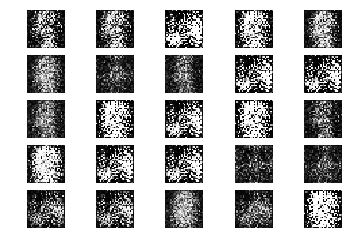

401 [D loss: 0.302348, acc.: 87.50%] [G loss: 3.327451]
402 [D loss: 0.344565, acc.: 82.81%] [G loss: 2.391972]
403 [D loss: 0.456549, acc.: 75.00%] [G loss: 2.618582]
404 [D loss: 0.340198, acc.: 85.94%] [G loss: 3.620152]
405 [D loss: 0.344808, acc.: 85.94%] [G loss: 2.970201]
406 [D loss: 0.443323, acc.: 82.81%] [G loss: 3.635224]
407 [D loss: 0.388014, acc.: 82.81%] [G loss: 3.560792]
408 [D loss: 0.778651, acc.: 56.25%] [G loss: 2.967316]
409 [D loss: 0.508005, acc.: 79.69%] [G loss: 3.427394]
410 [D loss: 0.486128, acc.: 78.12%] [G loss: 3.061115]
411 [D loss: 0.374150, acc.: 82.81%] [G loss: 2.605279]
412 [D loss: 0.248137, acc.: 84.38%] [G loss: 3.900737]
413 [D loss: 0.478579, acc.: 70.31%] [G loss: 2.418232]
414 [D loss: 0.234597, acc.: 87.50%] [G loss: 2.779771]
415 [D loss: 0.383798, acc.: 76.56%] [G loss: 3.512553]
416 [D loss: 0.539970, acc.: 67.19%] [G loss: 2.973974]
417 [D loss: 0.568919, acc.: 73.44%] [G loss: 2.988530]
418 [D loss: 0.767635, acc.: 56.25%] [G loss: 3.

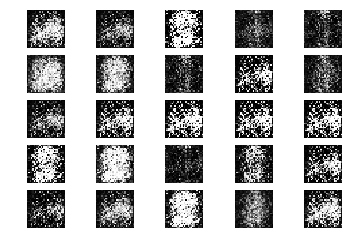

451 [D loss: 0.498492, acc.: 68.75%] [G loss: 2.766063]
452 [D loss: 0.590643, acc.: 81.25%] [G loss: 2.208358]
453 [D loss: 0.770088, acc.: 59.38%] [G loss: 2.795489]
454 [D loss: 0.557849, acc.: 68.75%] [G loss: 2.679598]
455 [D loss: 0.391761, acc.: 81.25%] [G loss: 2.289267]
456 [D loss: 0.436334, acc.: 79.69%] [G loss: 2.517495]
457 [D loss: 0.325837, acc.: 92.19%] [G loss: 2.592989]
458 [D loss: 0.845029, acc.: 59.38%] [G loss: 2.463079]
459 [D loss: 0.449717, acc.: 78.12%] [G loss: 2.758032]
460 [D loss: 0.536143, acc.: 76.56%] [G loss: 3.179698]
461 [D loss: 0.640389, acc.: 68.75%] [G loss: 2.061707]
462 [D loss: 0.446425, acc.: 82.81%] [G loss: 2.086484]
463 [D loss: 0.428976, acc.: 79.69%] [G loss: 2.695837]
464 [D loss: 0.552420, acc.: 79.69%] [G loss: 2.732100]
465 [D loss: 0.571187, acc.: 68.75%] [G loss: 2.316713]
466 [D loss: 0.505014, acc.: 73.44%] [G loss: 2.750730]
467 [D loss: 0.428677, acc.: 79.69%] [G loss: 2.408653]
468 [D loss: 0.441445, acc.: 79.69%] [G loss: 2.

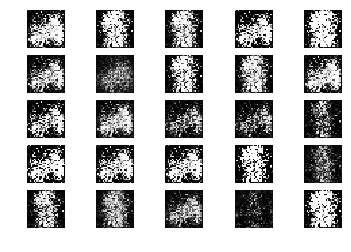

501 [D loss: 0.431657, acc.: 87.50%] [G loss: 2.575004]
502 [D loss: 0.639545, acc.: 70.31%] [G loss: 2.234139]
503 [D loss: 0.465281, acc.: 78.12%] [G loss: 2.376158]
504 [D loss: 0.462005, acc.: 73.44%] [G loss: 2.308371]
505 [D loss: 0.562617, acc.: 70.31%] [G loss: 2.268188]
506 [D loss: 0.480412, acc.: 81.25%] [G loss: 2.279389]
507 [D loss: 0.486958, acc.: 76.56%] [G loss: 2.305761]
508 [D loss: 0.707766, acc.: 62.50%] [G loss: 2.020308]
509 [D loss: 0.741537, acc.: 57.81%] [G loss: 2.096653]
510 [D loss: 0.690101, acc.: 59.38%] [G loss: 2.208556]
511 [D loss: 0.765257, acc.: 45.31%] [G loss: 2.259580]
512 [D loss: 0.524068, acc.: 67.19%] [G loss: 2.422856]
513 [D loss: 0.568815, acc.: 68.75%] [G loss: 1.894374]
514 [D loss: 0.475492, acc.: 78.12%] [G loss: 2.134507]
515 [D loss: 0.588356, acc.: 60.94%] [G loss: 2.137579]
516 [D loss: 0.474263, acc.: 71.88%] [G loss: 2.286453]
517 [D loss: 0.390853, acc.: 84.38%] [G loss: 2.407542]
518 [D loss: 0.546775, acc.: 65.62%] [G loss: 1.

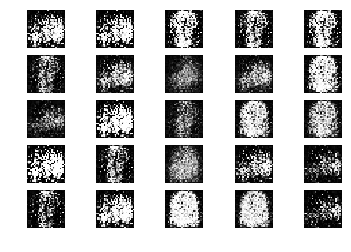

551 [D loss: 0.552364, acc.: 68.75%] [G loss: 1.747345]
552 [D loss: 0.535426, acc.: 70.31%] [G loss: 1.942938]
553 [D loss: 0.622349, acc.: 70.31%] [G loss: 1.728413]
554 [D loss: 0.650688, acc.: 67.19%] [G loss: 1.759141]
555 [D loss: 0.653636, acc.: 57.81%] [G loss: 1.615959]
556 [D loss: 0.615142, acc.: 67.19%] [G loss: 1.711000]
557 [D loss: 0.434506, acc.: 79.69%] [G loss: 1.900105]
558 [D loss: 0.697104, acc.: 59.38%] [G loss: 1.679071]
559 [D loss: 0.606054, acc.: 65.62%] [G loss: 1.834714]
560 [D loss: 0.631149, acc.: 60.94%] [G loss: 1.795873]
561 [D loss: 0.623370, acc.: 73.44%] [G loss: 2.003601]
562 [D loss: 0.651487, acc.: 57.81%] [G loss: 1.658710]
563 [D loss: 0.618636, acc.: 67.19%] [G loss: 1.973572]
564 [D loss: 0.491324, acc.: 84.38%] [G loss: 1.755364]
565 [D loss: 0.623206, acc.: 78.12%] [G loss: 1.669464]
566 [D loss: 0.604239, acc.: 51.56%] [G loss: 1.553640]
567 [D loss: 0.579355, acc.: 70.31%] [G loss: 1.959907]
568 [D loss: 0.576499, acc.: 78.12%] [G loss: 1.

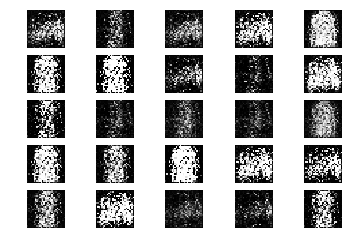

601 [D loss: 0.442910, acc.: 79.69%] [G loss: 1.652229]
602 [D loss: 0.517350, acc.: 75.00%] [G loss: 1.509165]
603 [D loss: 0.507443, acc.: 71.88%] [G loss: 1.829155]
604 [D loss: 0.580498, acc.: 78.12%] [G loss: 1.573850]
605 [D loss: 0.578839, acc.: 73.44%] [G loss: 1.461559]
606 [D loss: 0.571780, acc.: 68.75%] [G loss: 1.502927]
607 [D loss: 0.653429, acc.: 56.25%] [G loss: 1.474967]
608 [D loss: 0.406292, acc.: 82.81%] [G loss: 1.693341]
609 [D loss: 0.558643, acc.: 73.44%] [G loss: 1.449707]
610 [D loss: 0.504218, acc.: 71.88%] [G loss: 1.875911]
611 [D loss: 0.465691, acc.: 76.56%] [G loss: 1.593420]
612 [D loss: 0.643275, acc.: 68.75%] [G loss: 1.455601]
613 [D loss: 0.488974, acc.: 76.56%] [G loss: 1.767467]
614 [D loss: 0.499072, acc.: 84.38%] [G loss: 1.629427]
615 [D loss: 0.497914, acc.: 78.12%] [G loss: 1.689817]
616 [D loss: 0.574648, acc.: 76.56%] [G loss: 1.708438]
617 [D loss: 0.514536, acc.: 73.44%] [G loss: 1.752751]
618 [D loss: 0.639540, acc.: 59.38%] [G loss: 1.

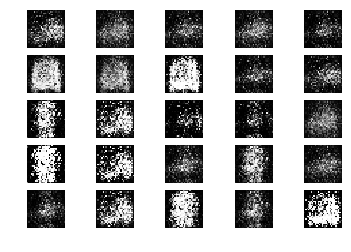

651 [D loss: 0.603242, acc.: 71.88%] [G loss: 1.434364]
652 [D loss: 0.588929, acc.: 71.88%] [G loss: 1.609442]
653 [D loss: 0.590771, acc.: 70.31%] [G loss: 1.472275]
654 [D loss: 0.488213, acc.: 79.69%] [G loss: 1.682371]
655 [D loss: 0.578910, acc.: 71.88%] [G loss: 1.605405]
656 [D loss: 0.616844, acc.: 67.19%] [G loss: 1.351044]
657 [D loss: 0.656891, acc.: 73.44%] [G loss: 1.328023]
658 [D loss: 0.574641, acc.: 70.31%] [G loss: 1.722520]
659 [D loss: 0.476416, acc.: 78.12%] [G loss: 1.940371]
660 [D loss: 0.573333, acc.: 65.62%] [G loss: 1.740723]
661 [D loss: 0.519581, acc.: 75.00%] [G loss: 1.615028]
662 [D loss: 0.604821, acc.: 65.62%] [G loss: 1.582674]
663 [D loss: 0.464440, acc.: 79.69%] [G loss: 1.727154]
664 [D loss: 0.562147, acc.: 73.44%] [G loss: 1.623587]
665 [D loss: 0.603530, acc.: 67.19%] [G loss: 1.620556]
666 [D loss: 0.531337, acc.: 78.12%] [G loss: 1.444735]
667 [D loss: 0.620867, acc.: 71.88%] [G loss: 1.600945]
668 [D loss: 0.493019, acc.: 73.44%] [G loss: 1.

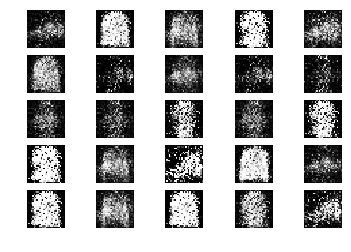

701 [D loss: 0.474730, acc.: 76.56%] [G loss: 1.607687]
702 [D loss: 0.472579, acc.: 81.25%] [G loss: 1.708691]
703 [D loss: 0.591944, acc.: 57.81%] [G loss: 1.277514]
704 [D loss: 0.631871, acc.: 57.81%] [G loss: 1.238269]
705 [D loss: 0.599397, acc.: 70.31%] [G loss: 1.365563]
706 [D loss: 0.625134, acc.: 64.06%] [G loss: 1.668252]
707 [D loss: 0.560800, acc.: 68.75%] [G loss: 1.428242]
708 [D loss: 0.667116, acc.: 64.06%] [G loss: 1.545892]
709 [D loss: 0.679292, acc.: 70.31%] [G loss: 1.379531]
710 [D loss: 0.584318, acc.: 68.75%] [G loss: 1.366209]
711 [D loss: 0.584107, acc.: 70.31%] [G loss: 1.274764]
712 [D loss: 0.563870, acc.: 71.88%] [G loss: 1.343568]
713 [D loss: 0.564482, acc.: 75.00%] [G loss: 1.498169]
714 [D loss: 0.496226, acc.: 84.38%] [G loss: 1.515964]
715 [D loss: 0.622340, acc.: 71.88%] [G loss: 1.407814]
716 [D loss: 0.512199, acc.: 79.69%] [G loss: 1.653243]
717 [D loss: 0.563740, acc.: 73.44%] [G loss: 1.315155]
718 [D loss: 0.637565, acc.: 59.38%] [G loss: 1.

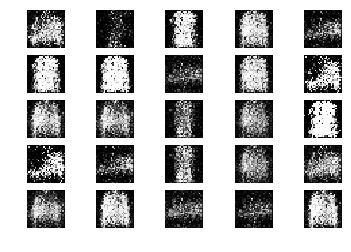

751 [D loss: 0.607923, acc.: 71.88%] [G loss: 1.410594]
752 [D loss: 0.609821, acc.: 57.81%] [G loss: 1.323416]
753 [D loss: 0.651926, acc.: 56.25%] [G loss: 1.270953]
754 [D loss: 0.582740, acc.: 70.31%] [G loss: 1.450149]
755 [D loss: 0.682331, acc.: 56.25%] [G loss: 1.212833]
756 [D loss: 0.694422, acc.: 53.12%] [G loss: 1.283505]
757 [D loss: 0.665745, acc.: 59.38%] [G loss: 1.308664]
758 [D loss: 0.625700, acc.: 64.06%] [G loss: 1.417662]
759 [D loss: 0.626573, acc.: 56.25%] [G loss: 1.281506]
760 [D loss: 0.591477, acc.: 76.56%] [G loss: 1.382077]
761 [D loss: 0.866266, acc.: 56.25%] [G loss: 1.345532]
762 [D loss: 0.719887, acc.: 53.12%] [G loss: 1.202359]
763 [D loss: 0.798235, acc.: 57.81%] [G loss: 1.003705]
764 [D loss: 0.608761, acc.: 64.06%] [G loss: 1.212679]
765 [D loss: 0.745360, acc.: 53.12%] [G loss: 1.387468]
766 [D loss: 0.580207, acc.: 62.50%] [G loss: 1.265235]
767 [D loss: 0.640773, acc.: 50.00%] [G loss: 1.342274]
768 [D loss: 0.602774, acc.: 73.44%] [G loss: 1.

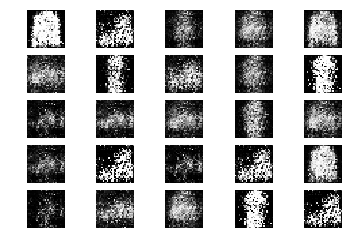

801 [D loss: 0.563494, acc.: 64.06%] [G loss: 1.343401]
802 [D loss: 0.574224, acc.: 71.88%] [G loss: 1.235940]
803 [D loss: 0.644570, acc.: 60.94%] [G loss: 1.113357]
804 [D loss: 0.643831, acc.: 59.38%] [G loss: 1.227310]
805 [D loss: 0.545864, acc.: 79.69%] [G loss: 1.481029]
806 [D loss: 0.790181, acc.: 50.00%] [G loss: 1.076406]
807 [D loss: 0.617606, acc.: 65.62%] [G loss: 1.072165]
808 [D loss: 0.638778, acc.: 60.94%] [G loss: 1.235655]
809 [D loss: 0.606010, acc.: 67.19%] [G loss: 1.293553]
810 [D loss: 0.700721, acc.: 62.50%] [G loss: 1.174120]
811 [D loss: 0.632001, acc.: 64.06%] [G loss: 1.173283]
812 [D loss: 0.580693, acc.: 68.75%] [G loss: 1.227024]
813 [D loss: 0.589862, acc.: 71.88%] [G loss: 1.188982]
814 [D loss: 0.720692, acc.: 62.50%] [G loss: 1.190170]
815 [D loss: 0.527641, acc.: 79.69%] [G loss: 1.398348]
816 [D loss: 0.542346, acc.: 79.69%] [G loss: 1.403373]
817 [D loss: 0.619591, acc.: 68.75%] [G loss: 1.123891]
818 [D loss: 0.648502, acc.: 65.62%] [G loss: 1.

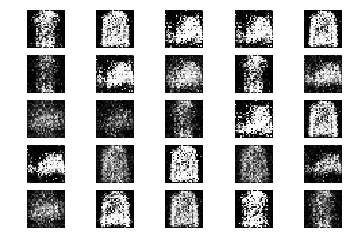

851 [D loss: 0.589602, acc.: 71.88%] [G loss: 1.368299]
852 [D loss: 0.654360, acc.: 65.62%] [G loss: 1.199693]
853 [D loss: 0.564731, acc.: 73.44%] [G loss: 1.113024]
854 [D loss: 0.612609, acc.: 65.62%] [G loss: 1.268412]
855 [D loss: 0.611135, acc.: 65.62%] [G loss: 1.201290]
856 [D loss: 0.671469, acc.: 64.06%] [G loss: 1.311496]
857 [D loss: 0.618523, acc.: 64.06%] [G loss: 1.088344]
858 [D loss: 0.699183, acc.: 56.25%] [G loss: 1.192795]
859 [D loss: 0.645884, acc.: 57.81%] [G loss: 1.173876]
860 [D loss: 0.582276, acc.: 68.75%] [G loss: 1.126858]
861 [D loss: 0.637263, acc.: 60.94%] [G loss: 1.120614]
862 [D loss: 0.688739, acc.: 56.25%] [G loss: 1.042848]
863 [D loss: 0.607140, acc.: 65.62%] [G loss: 1.187455]
864 [D loss: 0.599093, acc.: 62.50%] [G loss: 1.173323]
865 [D loss: 0.646899, acc.: 73.44%] [G loss: 1.215343]
866 [D loss: 0.584208, acc.: 68.75%] [G loss: 1.192306]
867 [D loss: 0.768860, acc.: 48.44%] [G loss: 1.141123]
868 [D loss: 0.623125, acc.: 67.19%] [G loss: 1.

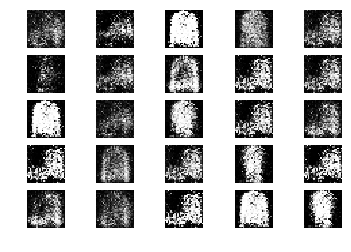

901 [D loss: 0.684440, acc.: 62.50%] [G loss: 1.113861]
902 [D loss: 0.694855, acc.: 51.56%] [G loss: 1.036870]
903 [D loss: 0.703900, acc.: 59.38%] [G loss: 1.021839]
904 [D loss: 0.678839, acc.: 64.06%] [G loss: 1.036070]
905 [D loss: 0.647483, acc.: 59.38%] [G loss: 1.148521]
906 [D loss: 0.662484, acc.: 59.38%] [G loss: 1.113197]
907 [D loss: 0.718112, acc.: 59.38%] [G loss: 1.178957]
908 [D loss: 0.781186, acc.: 39.06%] [G loss: 0.996922]
909 [D loss: 0.733272, acc.: 50.00%] [G loss: 1.045596]
910 [D loss: 0.734244, acc.: 42.19%] [G loss: 1.083320]
911 [D loss: 0.697552, acc.: 43.75%] [G loss: 1.074515]
912 [D loss: 0.695924, acc.: 46.88%] [G loss: 1.068993]
913 [D loss: 0.655747, acc.: 50.00%] [G loss: 1.058170]
914 [D loss: 0.721324, acc.: 46.88%] [G loss: 0.965721]
915 [D loss: 0.651875, acc.: 54.69%] [G loss: 1.153225]
916 [D loss: 0.708177, acc.: 48.44%] [G loss: 1.142523]
917 [D loss: 0.628491, acc.: 67.19%] [G loss: 1.002385]
918 [D loss: 0.624448, acc.: 70.31%] [G loss: 1.

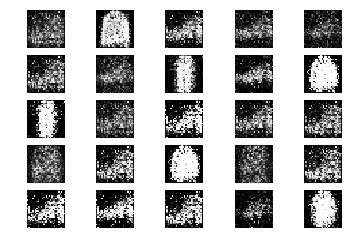

951 [D loss: 0.619930, acc.: 64.06%] [G loss: 1.069139]
952 [D loss: 0.649335, acc.: 65.62%] [G loss: 0.955142]
953 [D loss: 0.678131, acc.: 60.94%] [G loss: 1.070231]
954 [D loss: 0.649427, acc.: 64.06%] [G loss: 0.989593]
955 [D loss: 0.654070, acc.: 54.69%] [G loss: 0.966293]
956 [D loss: 0.676871, acc.: 59.38%] [G loss: 0.960680]
957 [D loss: 0.624829, acc.: 64.06%] [G loss: 0.938397]
958 [D loss: 0.654853, acc.: 64.06%] [G loss: 0.987744]
959 [D loss: 0.741183, acc.: 53.12%] [G loss: 1.068095]
960 [D loss: 0.717773, acc.: 50.00%] [G loss: 0.967068]
961 [D loss: 0.589733, acc.: 64.06%] [G loss: 1.073533]
962 [D loss: 0.686589, acc.: 64.06%] [G loss: 0.992819]
963 [D loss: 0.677111, acc.: 53.12%] [G loss: 1.019024]
964 [D loss: 0.723125, acc.: 48.44%] [G loss: 0.929050]
965 [D loss: 0.735498, acc.: 57.81%] [G loss: 1.012060]
966 [D loss: 0.776138, acc.: 37.50%] [G loss: 0.993053]
967 [D loss: 0.663369, acc.: 53.12%] [G loss: 0.935083]
968 [D loss: 0.755799, acc.: 45.31%] [G loss: 1.

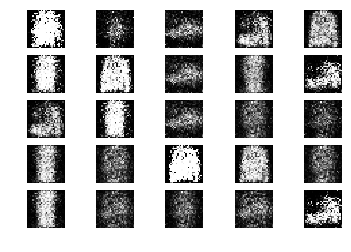

1001 [D loss: 0.667498, acc.: 53.12%] [G loss: 1.017885]
1002 [D loss: 0.724727, acc.: 46.88%] [G loss: 0.979539]
1003 [D loss: 0.734263, acc.: 43.75%] [G loss: 0.898963]
1004 [D loss: 0.725503, acc.: 50.00%] [G loss: 0.896579]
1005 [D loss: 0.702122, acc.: 48.44%] [G loss: 0.877990]
1006 [D loss: 0.753034, acc.: 54.69%] [G loss: 0.866822]
1007 [D loss: 0.688386, acc.: 46.88%] [G loss: 0.984969]
1008 [D loss: 0.647881, acc.: 68.75%] [G loss: 1.052875]
1009 [D loss: 0.748199, acc.: 42.19%] [G loss: 0.935844]
1010 [D loss: 0.762294, acc.: 54.69%] [G loss: 0.886236]
1011 [D loss: 0.743978, acc.: 50.00%] [G loss: 0.986633]
1012 [D loss: 0.755749, acc.: 39.06%] [G loss: 0.892502]
1013 [D loss: 0.718615, acc.: 51.56%] [G loss: 0.905560]
1014 [D loss: 0.612268, acc.: 65.62%] [G loss: 0.914513]
1015 [D loss: 0.674780, acc.: 54.69%] [G loss: 1.003203]
1016 [D loss: 0.683287, acc.: 53.12%] [G loss: 0.971867]
1017 [D loss: 0.710879, acc.: 42.19%] [G loss: 0.987312]
1018 [D loss: 0.647254, acc.: 6

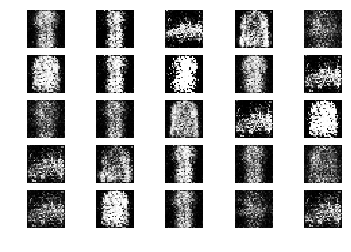

1051 [D loss: 0.706481, acc.: 48.44%] [G loss: 0.905991]
1052 [D loss: 0.790189, acc.: 34.38%] [G loss: 0.830618]
1053 [D loss: 0.696640, acc.: 50.00%] [G loss: 0.878175]
1054 [D loss: 0.694675, acc.: 51.56%] [G loss: 0.862444]
1055 [D loss: 0.784290, acc.: 53.12%] [G loss: 0.945968]
1056 [D loss: 0.658518, acc.: 54.69%] [G loss: 0.976888]
1057 [D loss: 0.748181, acc.: 59.38%] [G loss: 0.932013]
1058 [D loss: 0.733700, acc.: 51.56%] [G loss: 0.979742]
1059 [D loss: 0.726091, acc.: 59.38%] [G loss: 0.957010]
1060 [D loss: 0.662107, acc.: 68.75%] [G loss: 0.980710]
1061 [D loss: 0.683895, acc.: 57.81%] [G loss: 0.947133]
1062 [D loss: 0.682747, acc.: 57.81%] [G loss: 0.961552]
1063 [D loss: 0.732459, acc.: 53.12%] [G loss: 0.893430]
1064 [D loss: 0.673887, acc.: 56.25%] [G loss: 0.881408]
1065 [D loss: 0.654512, acc.: 62.50%] [G loss: 0.925886]
1066 [D loss: 0.743138, acc.: 42.19%] [G loss: 0.880925]
1067 [D loss: 0.696716, acc.: 54.69%] [G loss: 0.898447]
1068 [D loss: 0.690974, acc.: 5

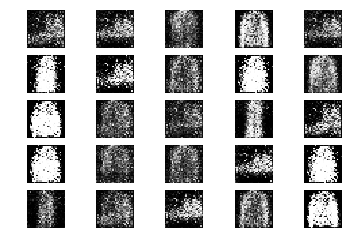

1101 [D loss: 0.740675, acc.: 54.69%] [G loss: 0.883482]
1102 [D loss: 0.733212, acc.: 53.12%] [G loss: 0.866369]
1103 [D loss: 0.733785, acc.: 56.25%] [G loss: 0.894813]
1104 [D loss: 0.736650, acc.: 54.69%] [G loss: 0.865030]
1105 [D loss: 0.691360, acc.: 50.00%] [G loss: 0.941764]
1106 [D loss: 0.724372, acc.: 43.75%] [G loss: 0.918844]
1107 [D loss: 0.668271, acc.: 60.94%] [G loss: 0.842970]
1108 [D loss: 0.708480, acc.: 57.81%] [G loss: 0.889896]
1109 [D loss: 0.702745, acc.: 51.56%] [G loss: 0.864983]
1110 [D loss: 0.685230, acc.: 60.94%] [G loss: 0.896156]
1111 [D loss: 0.665864, acc.: 62.50%] [G loss: 0.936177]
1112 [D loss: 0.630498, acc.: 70.31%] [G loss: 0.980502]
1113 [D loss: 0.667436, acc.: 65.62%] [G loss: 0.889045]
1114 [D loss: 0.690348, acc.: 64.06%] [G loss: 0.948810]
1115 [D loss: 0.680212, acc.: 54.69%] [G loss: 0.862173]
1116 [D loss: 0.715562, acc.: 53.12%] [G loss: 0.903129]
1117 [D loss: 0.656820, acc.: 65.62%] [G loss: 0.936998]
1118 [D loss: 0.625490, acc.: 6

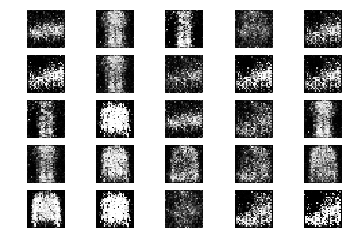

1151 [D loss: 0.732773, acc.: 54.69%] [G loss: 0.898538]
1152 [D loss: 0.698531, acc.: 56.25%] [G loss: 0.976198]
1153 [D loss: 0.694830, acc.: 56.25%] [G loss: 0.949018]
1154 [D loss: 0.650226, acc.: 67.19%] [G loss: 0.934904]
1155 [D loss: 0.750057, acc.: 51.56%] [G loss: 0.752373]
1156 [D loss: 0.695113, acc.: 57.81%] [G loss: 0.825672]
1157 [D loss: 0.699568, acc.: 56.25%] [G loss: 0.845942]
1158 [D loss: 0.710310, acc.: 51.56%] [G loss: 0.851748]
1159 [D loss: 0.678295, acc.: 60.94%] [G loss: 0.863448]
1160 [D loss: 0.641727, acc.: 68.75%] [G loss: 0.945204]
1161 [D loss: 0.711267, acc.: 64.06%] [G loss: 0.957069]
1162 [D loss: 0.665788, acc.: 62.50%] [G loss: 1.036098]
1163 [D loss: 0.657140, acc.: 65.62%] [G loss: 1.040916]
1164 [D loss: 0.667013, acc.: 68.75%] [G loss: 0.924378]
1165 [D loss: 0.742511, acc.: 48.44%] [G loss: 0.984806]
1166 [D loss: 0.678918, acc.: 67.19%] [G loss: 1.061305]
1167 [D loss: 0.654636, acc.: 62.50%] [G loss: 1.063673]
1168 [D loss: 0.676870, acc.: 6

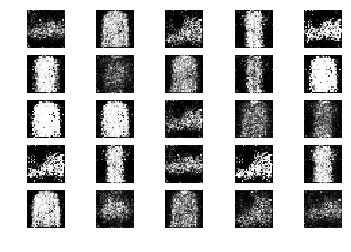

1201 [D loss: 0.730978, acc.: 45.31%] [G loss: 0.915812]
1202 [D loss: 0.764624, acc.: 42.19%] [G loss: 0.812176]
1203 [D loss: 0.709949, acc.: 56.25%] [G loss: 0.849700]
1204 [D loss: 0.735925, acc.: 37.50%] [G loss: 0.867361]
1205 [D loss: 0.728197, acc.: 50.00%] [G loss: 0.923840]
1206 [D loss: 0.751088, acc.: 48.44%] [G loss: 0.844567]
1207 [D loss: 0.705781, acc.: 50.00%] [G loss: 0.822825]
1208 [D loss: 0.697889, acc.: 45.31%] [G loss: 0.861434]
1209 [D loss: 0.675382, acc.: 67.19%] [G loss: 0.878263]
1210 [D loss: 0.663051, acc.: 50.00%] [G loss: 0.879438]
1211 [D loss: 0.644632, acc.: 65.62%] [G loss: 0.884327]
1212 [D loss: 0.712597, acc.: 51.56%] [G loss: 0.896490]
1213 [D loss: 0.726795, acc.: 46.88%] [G loss: 0.903091]
1214 [D loss: 0.709943, acc.: 48.44%] [G loss: 0.858591]
1215 [D loss: 0.722386, acc.: 57.81%] [G loss: 0.807982]
1216 [D loss: 0.702663, acc.: 54.69%] [G loss: 0.803978]
1217 [D loss: 0.694877, acc.: 59.38%] [G loss: 0.883275]
1218 [D loss: 0.679712, acc.: 5

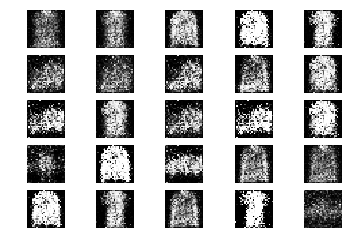

1251 [D loss: 0.642856, acc.: 65.62%] [G loss: 0.978160]
1252 [D loss: 0.668988, acc.: 56.25%] [G loss: 0.942488]
1253 [D loss: 0.689961, acc.: 54.69%] [G loss: 0.888377]
1254 [D loss: 0.665330, acc.: 67.19%] [G loss: 0.846612]
1255 [D loss: 0.681542, acc.: 57.81%] [G loss: 0.835199]
1256 [D loss: 0.705363, acc.: 48.44%] [G loss: 0.853826]
1257 [D loss: 0.643437, acc.: 64.06%] [G loss: 0.866909]
1258 [D loss: 0.627985, acc.: 70.31%] [G loss: 0.880192]
1259 [D loss: 0.629514, acc.: 59.38%] [G loss: 0.872146]
1260 [D loss: 0.593210, acc.: 73.44%] [G loss: 0.903162]
1261 [D loss: 0.636926, acc.: 62.50%] [G loss: 0.933056]
1262 [D loss: 0.623391, acc.: 64.06%] [G loss: 0.915530]
1263 [D loss: 0.628405, acc.: 60.94%] [G loss: 0.879954]
1264 [D loss: 0.632916, acc.: 65.62%] [G loss: 0.906136]
1265 [D loss: 0.639763, acc.: 67.19%] [G loss: 0.890278]
1266 [D loss: 0.621809, acc.: 64.06%] [G loss: 0.929432]
1267 [D loss: 0.640508, acc.: 65.62%] [G loss: 0.830305]
1268 [D loss: 0.641781, acc.: 6

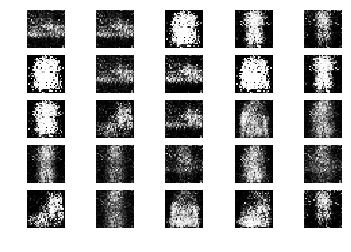

1301 [D loss: 0.715812, acc.: 51.56%] [G loss: 0.857820]
1302 [D loss: 0.682058, acc.: 59.38%] [G loss: 0.837881]
1303 [D loss: 0.661308, acc.: 57.81%] [G loss: 0.898393]
1304 [D loss: 0.665571, acc.: 56.25%] [G loss: 0.896672]
1305 [D loss: 0.643070, acc.: 65.62%] [G loss: 0.850746]
1306 [D loss: 0.649651, acc.: 67.19%] [G loss: 0.912004]
1307 [D loss: 0.645109, acc.: 56.25%] [G loss: 0.914710]
1308 [D loss: 0.672400, acc.: 54.69%] [G loss: 0.976376]
1309 [D loss: 0.713817, acc.: 56.25%] [G loss: 0.916440]
1310 [D loss: 0.650040, acc.: 65.62%] [G loss: 0.952624]
1311 [D loss: 0.705716, acc.: 51.56%] [G loss: 0.888407]
1312 [D loss: 0.716875, acc.: 51.56%] [G loss: 0.884248]
1313 [D loss: 0.650312, acc.: 56.25%] [G loss: 0.899796]
1314 [D loss: 0.633371, acc.: 70.31%] [G loss: 0.895936]
1315 [D loss: 0.657459, acc.: 62.50%] [G loss: 0.885009]
1316 [D loss: 0.641347, acc.: 68.75%] [G loss: 0.944476]
1317 [D loss: 0.617983, acc.: 62.50%] [G loss: 0.912679]
1318 [D loss: 0.626056, acc.: 6

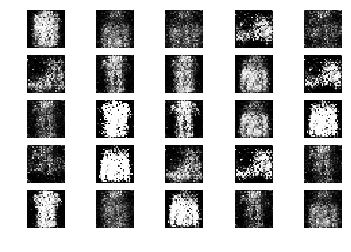

1351 [D loss: 0.677983, acc.: 57.81%] [G loss: 0.869444]
1352 [D loss: 0.585262, acc.: 76.56%] [G loss: 0.930613]
1353 [D loss: 0.577159, acc.: 75.00%] [G loss: 0.959495]
1354 [D loss: 0.632172, acc.: 67.19%] [G loss: 0.905658]
1355 [D loss: 0.624981, acc.: 60.94%] [G loss: 0.958350]
1356 [D loss: 0.615164, acc.: 64.06%] [G loss: 0.994457]
1357 [D loss: 0.610809, acc.: 62.50%] [G loss: 0.989416]
1358 [D loss: 0.602396, acc.: 71.88%] [G loss: 1.001166]
1359 [D loss: 0.586941, acc.: 71.88%] [G loss: 0.953115]
1360 [D loss: 0.606928, acc.: 71.88%] [G loss: 1.010733]
1361 [D loss: 0.622213, acc.: 59.38%] [G loss: 0.931249]
1362 [D loss: 0.619414, acc.: 70.31%] [G loss: 0.895125]
1363 [D loss: 0.643109, acc.: 62.50%] [G loss: 0.849186]
1364 [D loss: 0.601089, acc.: 68.75%] [G loss: 0.876330]
1365 [D loss: 0.599098, acc.: 76.56%] [G loss: 0.889131]
1366 [D loss: 0.670714, acc.: 54.69%] [G loss: 0.988762]
1367 [D loss: 0.587212, acc.: 73.44%] [G loss: 0.953727]
1368 [D loss: 0.617048, acc.: 6

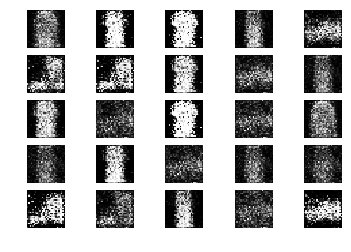

1401 [D loss: 0.691019, acc.: 56.25%] [G loss: 0.916138]
1402 [D loss: 0.737214, acc.: 35.94%] [G loss: 0.894882]
1403 [D loss: 0.680617, acc.: 57.81%] [G loss: 0.911711]
1404 [D loss: 0.661778, acc.: 53.12%] [G loss: 0.890007]
1405 [D loss: 0.686914, acc.: 56.25%] [G loss: 0.851560]
1406 [D loss: 0.675696, acc.: 56.25%] [G loss: 0.965040]
1407 [D loss: 0.668935, acc.: 64.06%] [G loss: 0.959559]
1408 [D loss: 0.695417, acc.: 51.56%] [G loss: 0.884846]
1409 [D loss: 0.674449, acc.: 59.38%] [G loss: 0.906351]
1410 [D loss: 0.757360, acc.: 42.19%] [G loss: 0.866596]
1411 [D loss: 0.664881, acc.: 51.56%] [G loss: 0.915686]
1412 [D loss: 0.730299, acc.: 40.62%] [G loss: 0.888757]
1413 [D loss: 0.675646, acc.: 59.38%] [G loss: 0.952681]
1414 [D loss: 0.740554, acc.: 46.88%] [G loss: 0.923234]
1415 [D loss: 0.610550, acc.: 67.19%] [G loss: 0.985793]
1416 [D loss: 0.687943, acc.: 51.56%] [G loss: 1.003811]
1417 [D loss: 0.695762, acc.: 45.31%] [G loss: 0.939994]
1418 [D loss: 0.651816, acc.: 5

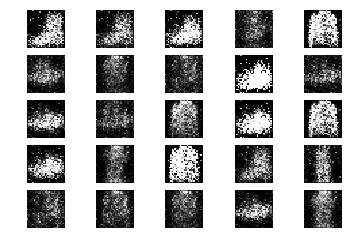

1451 [D loss: 0.594493, acc.: 64.06%] [G loss: 0.855987]
1452 [D loss: 0.636871, acc.: 62.50%] [G loss: 0.901408]
1453 [D loss: 0.662030, acc.: 65.62%] [G loss: 0.901449]
1454 [D loss: 0.659099, acc.: 59.38%] [G loss: 0.927909]
1455 [D loss: 0.688911, acc.: 60.94%] [G loss: 0.884737]
1456 [D loss: 0.716514, acc.: 54.69%] [G loss: 0.932321]
1457 [D loss: 0.684258, acc.: 59.38%] [G loss: 0.934390]
1458 [D loss: 0.667040, acc.: 56.25%] [G loss: 0.877915]
1459 [D loss: 0.672661, acc.: 59.38%] [G loss: 0.835695]
1460 [D loss: 0.625961, acc.: 60.94%] [G loss: 0.885730]
1461 [D loss: 0.619257, acc.: 68.75%] [G loss: 0.872347]
1462 [D loss: 0.668607, acc.: 54.69%] [G loss: 0.824421]
1463 [D loss: 0.648947, acc.: 65.62%] [G loss: 0.864476]
1464 [D loss: 0.644970, acc.: 62.50%] [G loss: 0.917001]
1465 [D loss: 0.645717, acc.: 65.62%] [G loss: 0.843983]
1466 [D loss: 0.677102, acc.: 53.12%] [G loss: 0.902322]
1467 [D loss: 0.623259, acc.: 62.50%] [G loss: 0.988305]
1468 [D loss: 0.657267, acc.: 6

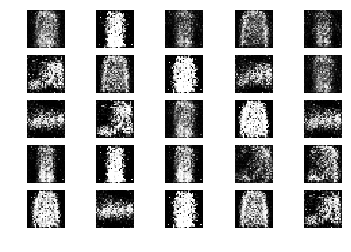

1501 [D loss: 0.639048, acc.: 62.50%] [G loss: 0.878901]
1502 [D loss: 0.637742, acc.: 62.50%] [G loss: 0.870160]
1503 [D loss: 0.565937, acc.: 68.75%] [G loss: 0.996470]
1504 [D loss: 0.678766, acc.: 57.81%] [G loss: 0.910127]
1505 [D loss: 0.666079, acc.: 56.25%] [G loss: 0.906259]
1506 [D loss: 0.635677, acc.: 56.25%] [G loss: 0.964399]
1507 [D loss: 0.598219, acc.: 65.62%] [G loss: 0.969500]
1508 [D loss: 0.664404, acc.: 57.81%] [G loss: 0.911042]
1509 [D loss: 0.622413, acc.: 62.50%] [G loss: 0.980919]
1510 [D loss: 0.708723, acc.: 53.12%] [G loss: 0.993532]
1511 [D loss: 0.720028, acc.: 51.56%] [G loss: 0.873467]
1512 [D loss: 0.655645, acc.: 60.94%] [G loss: 0.901499]
1513 [D loss: 0.704418, acc.: 57.81%] [G loss: 0.940187]
1514 [D loss: 0.790963, acc.: 40.62%] [G loss: 0.981590]
1515 [D loss: 0.651997, acc.: 57.81%] [G loss: 1.044063]
1516 [D loss: 0.669009, acc.: 53.12%] [G loss: 0.884909]
1517 [D loss: 0.686509, acc.: 60.94%] [G loss: 0.901125]
1518 [D loss: 0.758232, acc.: 4

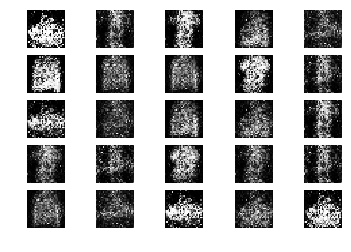

1551 [D loss: 0.616226, acc.: 64.06%] [G loss: 1.030618]
1552 [D loss: 0.555746, acc.: 71.88%] [G loss: 1.069340]
1553 [D loss: 0.568766, acc.: 73.44%] [G loss: 1.019480]
1554 [D loss: 0.572133, acc.: 71.88%] [G loss: 1.041361]
1555 [D loss: 0.501762, acc.: 84.38%] [G loss: 1.092865]
1556 [D loss: 0.626045, acc.: 64.06%] [G loss: 1.022900]
1557 [D loss: 0.557642, acc.: 75.00%] [G loss: 0.979062]
1558 [D loss: 0.518509, acc.: 82.81%] [G loss: 1.078265]
1559 [D loss: 0.564352, acc.: 68.75%] [G loss: 1.079226]
1560 [D loss: 0.563399, acc.: 76.56%] [G loss: 1.127081]
1561 [D loss: 0.584295, acc.: 76.56%] [G loss: 0.995457]
1562 [D loss: 0.641187, acc.: 54.69%] [G loss: 1.002603]
1563 [D loss: 0.623121, acc.: 67.19%] [G loss: 0.975178]
1564 [D loss: 0.601073, acc.: 60.94%] [G loss: 0.999120]
1565 [D loss: 0.558323, acc.: 75.00%] [G loss: 1.072225]
1566 [D loss: 0.609890, acc.: 71.88%] [G loss: 1.117888]
1567 [D loss: 0.688642, acc.: 62.50%] [G loss: 1.042464]
1568 [D loss: 0.686277, acc.: 6

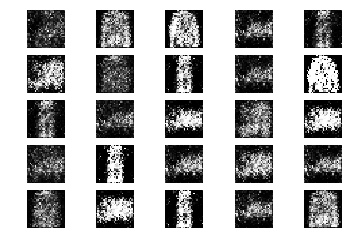

1601 [D loss: 0.627905, acc.: 64.06%] [G loss: 1.081615]
1602 [D loss: 0.611522, acc.: 65.62%] [G loss: 1.062471]
1603 [D loss: 0.713216, acc.: 53.12%] [G loss: 1.063357]
1604 [D loss: 0.574755, acc.: 71.88%] [G loss: 1.144858]
1605 [D loss: 0.595137, acc.: 71.88%] [G loss: 1.049389]
1606 [D loss: 0.607048, acc.: 71.88%] [G loss: 1.076323]
1607 [D loss: 0.622720, acc.: 67.19%] [G loss: 0.946406]
1608 [D loss: 0.558535, acc.: 71.88%] [G loss: 0.940203]
1609 [D loss: 0.645712, acc.: 54.69%] [G loss: 1.035548]
1610 [D loss: 0.639109, acc.: 54.69%] [G loss: 1.057950]
1611 [D loss: 0.627761, acc.: 64.06%] [G loss: 1.106129]
1612 [D loss: 0.535148, acc.: 79.69%] [G loss: 1.103040]
1613 [D loss: 0.593826, acc.: 70.31%] [G loss: 1.092857]
1614 [D loss: 0.614135, acc.: 70.31%] [G loss: 1.043295]
1615 [D loss: 0.574205, acc.: 70.31%] [G loss: 1.058543]
1616 [D loss: 0.593563, acc.: 67.19%] [G loss: 1.006217]
1617 [D loss: 0.607940, acc.: 71.88%] [G loss: 1.060446]
1618 [D loss: 0.632161, acc.: 6

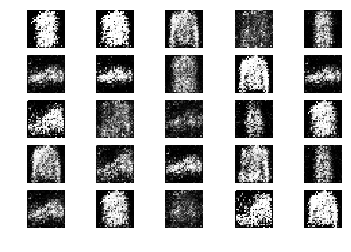

1651 [D loss: 0.663546, acc.: 48.44%] [G loss: 1.029493]
1652 [D loss: 0.646659, acc.: 57.81%] [G loss: 1.025112]
1653 [D loss: 0.672103, acc.: 51.56%] [G loss: 0.960680]
1654 [D loss: 0.656455, acc.: 53.12%] [G loss: 0.913767]
1655 [D loss: 0.667194, acc.: 59.38%] [G loss: 0.853479]
1656 [D loss: 0.666570, acc.: 53.12%] [G loss: 0.896555]
1657 [D loss: 0.682266, acc.: 48.44%] [G loss: 0.936796]
1658 [D loss: 0.690679, acc.: 46.88%] [G loss: 1.008444]
1659 [D loss: 0.703804, acc.: 46.88%] [G loss: 1.019597]
1660 [D loss: 0.694889, acc.: 46.88%] [G loss: 0.876561]
1661 [D loss: 0.603061, acc.: 64.06%] [G loss: 0.871510]
1662 [D loss: 0.650667, acc.: 57.81%] [G loss: 0.826378]
1663 [D loss: 0.603441, acc.: 57.81%] [G loss: 1.026892]
1664 [D loss: 0.650897, acc.: 57.81%] [G loss: 1.013762]
1665 [D loss: 0.718500, acc.: 51.56%] [G loss: 0.929541]
1666 [D loss: 0.623023, acc.: 68.75%] [G loss: 0.823300]
1667 [D loss: 0.682406, acc.: 56.25%] [G loss: 0.922989]
1668 [D loss: 0.638815, acc.: 6

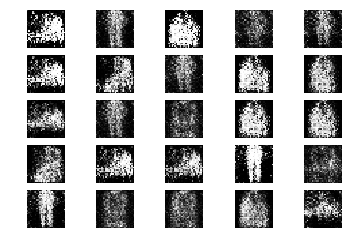

1701 [D loss: 0.665837, acc.: 56.25%] [G loss: 0.931159]
1702 [D loss: 0.588094, acc.: 64.06%] [G loss: 0.964604]
1703 [D loss: 0.600080, acc.: 65.62%] [G loss: 1.043891]
1704 [D loss: 0.676226, acc.: 60.94%] [G loss: 0.958335]
1705 [D loss: 0.586810, acc.: 75.00%] [G loss: 0.923098]
1706 [D loss: 0.628316, acc.: 68.75%] [G loss: 0.990702]
1707 [D loss: 0.650754, acc.: 68.75%] [G loss: 0.942657]
1708 [D loss: 0.560121, acc.: 81.25%] [G loss: 1.052163]
1709 [D loss: 0.647695, acc.: 70.31%] [G loss: 1.034230]
1710 [D loss: 0.653032, acc.: 68.75%] [G loss: 0.926449]
1711 [D loss: 0.704936, acc.: 46.88%] [G loss: 0.881568]
1712 [D loss: 0.653003, acc.: 54.69%] [G loss: 0.981699]
1713 [D loss: 0.671305, acc.: 64.06%] [G loss: 0.920120]
1714 [D loss: 0.686567, acc.: 53.12%] [G loss: 0.958242]
1715 [D loss: 0.626131, acc.: 62.50%] [G loss: 0.936511]
1716 [D loss: 0.672049, acc.: 57.81%] [G loss: 0.955422]
1717 [D loss: 0.711752, acc.: 53.12%] [G loss: 0.777814]
1718 [D loss: 0.694933, acc.: 5

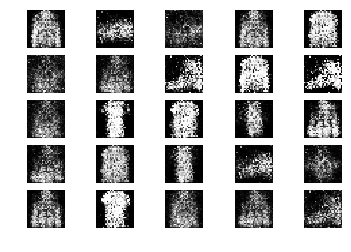

1751 [D loss: 0.656495, acc.: 54.69%] [G loss: 0.921165]
1752 [D loss: 0.560380, acc.: 68.75%] [G loss: 0.952028]
1753 [D loss: 0.584604, acc.: 75.00%] [G loss: 1.009834]
1754 [D loss: 0.606200, acc.: 75.00%] [G loss: 1.039448]
1755 [D loss: 0.595761, acc.: 73.44%] [G loss: 1.049774]
1756 [D loss: 0.647808, acc.: 56.25%] [G loss: 1.002358]
1757 [D loss: 0.752607, acc.: 45.31%] [G loss: 0.931960]
1758 [D loss: 0.645985, acc.: 64.06%] [G loss: 0.918330]
1759 [D loss: 0.675879, acc.: 65.62%] [G loss: 0.951442]
1760 [D loss: 0.615033, acc.: 67.19%] [G loss: 0.909580]
1761 [D loss: 0.584684, acc.: 73.44%] [G loss: 0.956611]
1762 [D loss: 0.576726, acc.: 75.00%] [G loss: 0.990911]
1763 [D loss: 0.666806, acc.: 64.06%] [G loss: 0.978927]
1764 [D loss: 0.678348, acc.: 54.69%] [G loss: 1.051859]
1765 [D loss: 0.600862, acc.: 68.75%] [G loss: 1.028854]
1766 [D loss: 0.608550, acc.: 53.12%] [G loss: 1.082572]
1767 [D loss: 0.624451, acc.: 67.19%] [G loss: 1.077344]
1768 [D loss: 0.593438, acc.: 7

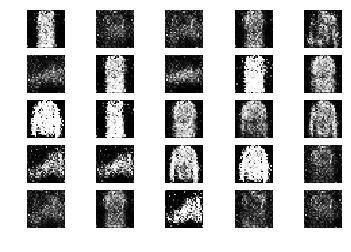

1801 [D loss: 0.667680, acc.: 53.12%] [G loss: 0.853091]
1802 [D loss: 0.617756, acc.: 65.62%] [G loss: 0.911488]
1803 [D loss: 0.633407, acc.: 57.81%] [G loss: 0.881767]
1804 [D loss: 0.665821, acc.: 57.81%] [G loss: 0.950514]
1805 [D loss: 0.685779, acc.: 51.56%] [G loss: 0.943729]
1806 [D loss: 0.664043, acc.: 67.19%] [G loss: 0.976089]
1807 [D loss: 0.672923, acc.: 60.94%] [G loss: 0.912422]
1808 [D loss: 0.758247, acc.: 45.31%] [G loss: 0.842835]
1809 [D loss: 0.671721, acc.: 51.56%] [G loss: 0.859197]
1810 [D loss: 0.598450, acc.: 71.88%] [G loss: 0.897771]
1811 [D loss: 0.717999, acc.: 42.19%] [G loss: 0.948163]
1812 [D loss: 0.668371, acc.: 57.81%] [G loss: 0.938347]
1813 [D loss: 0.689786, acc.: 53.12%] [G loss: 0.930769]
1814 [D loss: 0.646224, acc.: 59.38%] [G loss: 0.952990]
1815 [D loss: 0.676514, acc.: 65.62%] [G loss: 0.920455]
1816 [D loss: 0.696203, acc.: 46.88%] [G loss: 0.980990]
1817 [D loss: 0.698091, acc.: 59.38%] [G loss: 0.898422]
1818 [D loss: 0.672062, acc.: 5

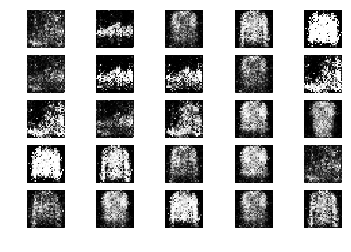

1851 [D loss: 0.685401, acc.: 51.56%] [G loss: 0.899901]
1852 [D loss: 0.695831, acc.: 59.38%] [G loss: 0.918386]
1853 [D loss: 0.585258, acc.: 65.62%] [G loss: 0.962728]
1854 [D loss: 0.586315, acc.: 82.81%] [G loss: 0.968709]
1855 [D loss: 0.650764, acc.: 62.50%] [G loss: 0.924080]
1856 [D loss: 0.635011, acc.: 67.19%] [G loss: 0.939501]
1857 [D loss: 0.594245, acc.: 78.12%] [G loss: 1.013392]
1858 [D loss: 0.616452, acc.: 75.00%] [G loss: 0.973238]
1859 [D loss: 0.708177, acc.: 51.56%] [G loss: 0.866918]
1860 [D loss: 0.602849, acc.: 71.88%] [G loss: 0.876200]
1861 [D loss: 0.610784, acc.: 73.44%] [G loss: 0.941505]
1862 [D loss: 0.624078, acc.: 67.19%] [G loss: 0.990880]
1863 [D loss: 0.658853, acc.: 56.25%] [G loss: 0.919718]
1864 [D loss: 0.583509, acc.: 68.75%] [G loss: 0.925579]
1865 [D loss: 0.596179, acc.: 70.31%] [G loss: 0.999296]
1866 [D loss: 0.694135, acc.: 67.19%] [G loss: 0.887489]
1867 [D loss: 0.657202, acc.: 62.50%] [G loss: 0.814214]
1868 [D loss: 0.651591, acc.: 5

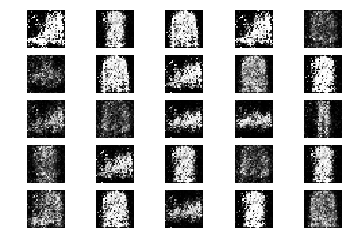

1901 [D loss: 0.729629, acc.: 45.31%] [G loss: 0.953904]
1902 [D loss: 0.632019, acc.: 60.94%] [G loss: 0.912548]
1903 [D loss: 0.638036, acc.: 57.81%] [G loss: 0.942645]
1904 [D loss: 0.689249, acc.: 56.25%] [G loss: 0.950533]
1905 [D loss: 0.640119, acc.: 56.25%] [G loss: 1.082293]
1906 [D loss: 0.667810, acc.: 60.94%] [G loss: 0.965514]
1907 [D loss: 0.697719, acc.: 51.56%] [G loss: 0.979544]
1908 [D loss: 0.657516, acc.: 57.81%] [G loss: 0.962439]
1909 [D loss: 0.641074, acc.: 65.62%] [G loss: 0.965448]
1910 [D loss: 0.635427, acc.: 54.69%] [G loss: 0.997843]
1911 [D loss: 0.634782, acc.: 60.94%] [G loss: 0.981238]
1912 [D loss: 0.595238, acc.: 67.19%] [G loss: 0.896807]
1913 [D loss: 0.638545, acc.: 62.50%] [G loss: 0.936410]
1914 [D loss: 0.614534, acc.: 65.62%] [G loss: 0.964467]
1915 [D loss: 0.635838, acc.: 65.62%] [G loss: 1.004798]
1916 [D loss: 0.592343, acc.: 68.75%] [G loss: 0.934477]
1917 [D loss: 0.648521, acc.: 62.50%] [G loss: 0.938868]
1918 [D loss: 0.548777, acc.: 6

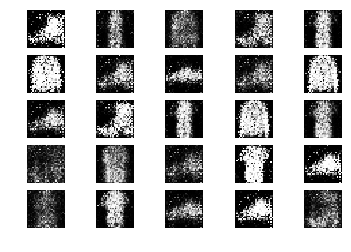

1951 [D loss: 0.650101, acc.: 60.94%] [G loss: 0.956035]
1952 [D loss: 0.573531, acc.: 76.56%] [G loss: 1.009665]
1953 [D loss: 0.638760, acc.: 60.94%] [G loss: 0.911924]
1954 [D loss: 0.588097, acc.: 62.50%] [G loss: 0.938621]
1955 [D loss: 0.596268, acc.: 65.62%] [G loss: 1.053936]
1956 [D loss: 0.630185, acc.: 65.62%] [G loss: 0.940090]
1957 [D loss: 0.641298, acc.: 56.25%] [G loss: 0.964474]
1958 [D loss: 0.646477, acc.: 67.19%] [G loss: 0.986502]
1959 [D loss: 0.649859, acc.: 64.06%] [G loss: 0.883010]
1960 [D loss: 0.680050, acc.: 54.69%] [G loss: 0.910645]
1961 [D loss: 0.607124, acc.: 65.62%] [G loss: 0.923887]
1962 [D loss: 0.558747, acc.: 82.81%] [G loss: 0.876150]
1963 [D loss: 0.592750, acc.: 68.75%] [G loss: 0.956479]
1964 [D loss: 0.587477, acc.: 73.44%] [G loss: 1.006141]
1965 [D loss: 0.559677, acc.: 73.44%] [G loss: 0.978326]
1966 [D loss: 0.606149, acc.: 65.62%] [G loss: 0.870458]
1967 [D loss: 0.610000, acc.: 76.56%] [G loss: 0.915904]
1968 [D loss: 0.620326, acc.: 6

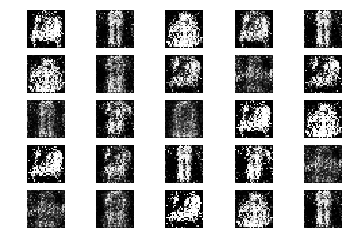

2001 [D loss: 0.532081, acc.: 73.44%] [G loss: 1.172799]
2002 [D loss: 0.512035, acc.: 79.69%] [G loss: 1.243427]
2003 [D loss: 0.543787, acc.: 67.19%] [G loss: 1.135321]
2004 [D loss: 0.574374, acc.: 70.31%] [G loss: 1.427995]
2005 [D loss: 0.475957, acc.: 85.94%] [G loss: 1.261097]
2006 [D loss: 0.504439, acc.: 79.69%] [G loss: 1.304531]
2007 [D loss: 0.530138, acc.: 78.12%] [G loss: 1.268381]
2008 [D loss: 0.510817, acc.: 76.56%] [G loss: 1.283518]
2009 [D loss: 0.646055, acc.: 53.12%] [G loss: 1.044062]
2010 [D loss: 0.544298, acc.: 71.88%] [G loss: 1.205438]
2011 [D loss: 0.499630, acc.: 76.56%] [G loss: 1.185152]
2012 [D loss: 0.571501, acc.: 71.88%] [G loss: 1.086432]
2013 [D loss: 0.542436, acc.: 68.75%] [G loss: 1.067340]
2014 [D loss: 0.685584, acc.: 53.12%] [G loss: 1.141049]
2015 [D loss: 0.575767, acc.: 71.88%] [G loss: 1.169081]
2016 [D loss: 0.598875, acc.: 76.56%] [G loss: 1.135590]
2017 [D loss: 0.622429, acc.: 62.50%] [G loss: 0.999706]
2018 [D loss: 0.549477, acc.: 7

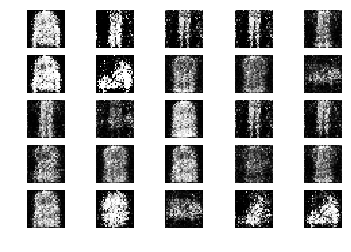

2051 [D loss: 0.655235, acc.: 65.62%] [G loss: 1.038733]
2052 [D loss: 0.625520, acc.: 64.06%] [G loss: 0.948361]
2053 [D loss: 0.611309, acc.: 68.75%] [G loss: 1.060317]
2054 [D loss: 0.663548, acc.: 60.94%] [G loss: 0.935444]
2055 [D loss: 0.608492, acc.: 75.00%] [G loss: 1.099579]
2056 [D loss: 0.534523, acc.: 78.12%] [G loss: 1.034627]
2057 [D loss: 0.677818, acc.: 59.38%] [G loss: 1.007499]
2058 [D loss: 0.728379, acc.: 56.25%] [G loss: 0.852226]
2059 [D loss: 0.645495, acc.: 60.94%] [G loss: 0.988648]
2060 [D loss: 0.650207, acc.: 60.94%] [G loss: 1.033415]
2061 [D loss: 0.634144, acc.: 57.81%] [G loss: 0.951727]
2062 [D loss: 0.761715, acc.: 51.56%] [G loss: 1.044400]
2063 [D loss: 0.544740, acc.: 79.69%] [G loss: 1.092551]
2064 [D loss: 0.625361, acc.: 68.75%] [G loss: 1.045562]
2065 [D loss: 0.760404, acc.: 48.44%] [G loss: 0.920645]
2066 [D loss: 0.646827, acc.: 59.38%] [G loss: 0.927649]
2067 [D loss: 0.759714, acc.: 42.19%] [G loss: 0.952381]
2068 [D loss: 0.572341, acc.: 7

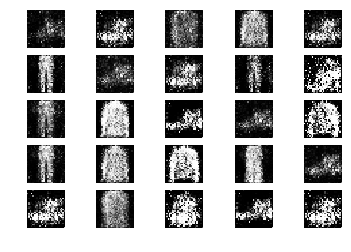

2101 [D loss: 0.784893, acc.: 45.31%] [G loss: 0.962556]
2102 [D loss: 0.633522, acc.: 62.50%] [G loss: 0.977282]
2103 [D loss: 0.627259, acc.: 60.94%] [G loss: 0.970407]
2104 [D loss: 0.641184, acc.: 50.00%] [G loss: 0.996143]
2105 [D loss: 0.678749, acc.: 54.69%] [G loss: 0.971721]
2106 [D loss: 0.639732, acc.: 54.69%] [G loss: 0.971657]
2107 [D loss: 0.572299, acc.: 75.00%] [G loss: 1.000868]
2108 [D loss: 0.659213, acc.: 59.38%] [G loss: 1.053221]
2109 [D loss: 0.645083, acc.: 59.38%] [G loss: 0.962067]
2110 [D loss: 0.623034, acc.: 64.06%] [G loss: 0.969682]
2111 [D loss: 0.651931, acc.: 64.06%] [G loss: 0.913541]
2112 [D loss: 0.599422, acc.: 62.50%] [G loss: 0.925657]
2113 [D loss: 0.746279, acc.: 48.44%] [G loss: 0.888581]
2114 [D loss: 0.684797, acc.: 51.56%] [G loss: 0.996823]
2115 [D loss: 0.646321, acc.: 62.50%] [G loss: 0.952752]
2116 [D loss: 0.641068, acc.: 59.38%] [G loss: 1.041848]
2117 [D loss: 0.606771, acc.: 62.50%] [G loss: 0.979825]
2118 [D loss: 0.647175, acc.: 5

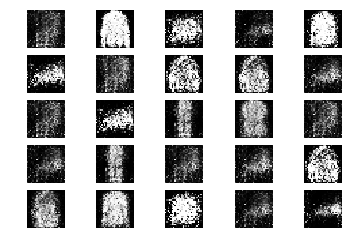

2151 [D loss: 0.627866, acc.: 65.62%] [G loss: 1.170151]
2152 [D loss: 0.626050, acc.: 65.62%] [G loss: 1.021519]
2153 [D loss: 0.620851, acc.: 62.50%] [G loss: 1.135613]
2154 [D loss: 0.625055, acc.: 62.50%] [G loss: 1.084695]
2155 [D loss: 0.648483, acc.: 62.50%] [G loss: 1.047525]
2156 [D loss: 0.704914, acc.: 50.00%] [G loss: 0.902287]
2157 [D loss: 0.638642, acc.: 59.38%] [G loss: 0.933021]
2158 [D loss: 0.641056, acc.: 60.94%] [G loss: 0.923887]
2159 [D loss: 0.597132, acc.: 75.00%] [G loss: 1.059201]
2160 [D loss: 0.634295, acc.: 65.62%] [G loss: 0.980822]
2161 [D loss: 0.639121, acc.: 57.81%] [G loss: 0.947394]
2162 [D loss: 0.581077, acc.: 70.31%] [G loss: 1.037950]
2163 [D loss: 0.597029, acc.: 70.31%] [G loss: 1.024238]
2164 [D loss: 0.628672, acc.: 60.94%] [G loss: 0.972174]
2165 [D loss: 0.538036, acc.: 75.00%] [G loss: 0.962832]
2166 [D loss: 0.616640, acc.: 65.62%] [G loss: 1.039994]
2167 [D loss: 0.588132, acc.: 70.31%] [G loss: 1.006783]
2168 [D loss: 0.676292, acc.: 6

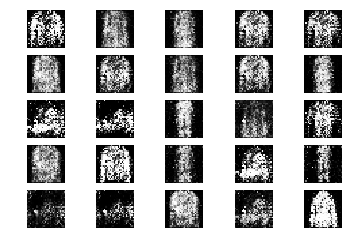

2201 [D loss: 0.686385, acc.: 59.38%] [G loss: 0.990759]
2202 [D loss: 0.614243, acc.: 65.62%] [G loss: 1.036801]
2203 [D loss: 0.597131, acc.: 73.44%] [G loss: 0.997840]
2204 [D loss: 0.597407, acc.: 64.06%] [G loss: 0.983173]
2205 [D loss: 0.605336, acc.: 68.75%] [G loss: 1.049787]
2206 [D loss: 0.587489, acc.: 70.31%] [G loss: 1.075355]
2207 [D loss: 0.577851, acc.: 73.44%] [G loss: 0.991304]
2208 [D loss: 0.575197, acc.: 73.44%] [G loss: 1.107590]
2209 [D loss: 0.655530, acc.: 60.94%] [G loss: 0.982763]
2210 [D loss: 0.648378, acc.: 54.69%] [G loss: 0.960565]
2211 [D loss: 0.585888, acc.: 65.62%] [G loss: 1.077763]
2212 [D loss: 0.568697, acc.: 68.75%] [G loss: 1.028556]
2213 [D loss: 0.623615, acc.: 60.94%] [G loss: 1.042761]
2214 [D loss: 0.571417, acc.: 68.75%] [G loss: 1.103042]
2215 [D loss: 0.620837, acc.: 62.50%] [G loss: 1.006343]
2216 [D loss: 0.590191, acc.: 62.50%] [G loss: 1.029952]
2217 [D loss: 0.594048, acc.: 68.75%] [G loss: 1.109157]
2218 [D loss: 0.606943, acc.: 6

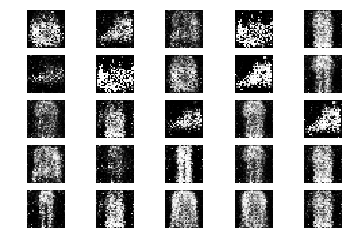

2251 [D loss: 0.633285, acc.: 62.50%] [G loss: 1.124414]
2252 [D loss: 0.663090, acc.: 56.25%] [G loss: 1.044285]
2253 [D loss: 0.664789, acc.: 71.88%] [G loss: 0.979736]
2254 [D loss: 0.664207, acc.: 59.38%] [G loss: 0.968466]
2255 [D loss: 0.719398, acc.: 48.44%] [G loss: 0.923482]
2256 [D loss: 0.614145, acc.: 64.06%] [G loss: 0.899750]
2257 [D loss: 0.585692, acc.: 70.31%] [G loss: 1.030939]
2258 [D loss: 0.623853, acc.: 68.75%] [G loss: 1.029309]
2259 [D loss: 0.634866, acc.: 62.50%] [G loss: 1.075785]
2260 [D loss: 0.620376, acc.: 71.88%] [G loss: 1.034222]
2261 [D loss: 0.612657, acc.: 60.94%] [G loss: 1.028851]
2262 [D loss: 0.636158, acc.: 70.31%] [G loss: 1.025059]
2263 [D loss: 0.632993, acc.: 68.75%] [G loss: 0.976299]
2264 [D loss: 0.629678, acc.: 67.19%] [G loss: 0.945882]
2265 [D loss: 0.639936, acc.: 56.25%] [G loss: 1.008786]
2266 [D loss: 0.651576, acc.: 68.75%] [G loss: 1.084507]
2267 [D loss: 0.643624, acc.: 57.81%] [G loss: 1.023824]
2268 [D loss: 0.646080, acc.: 6

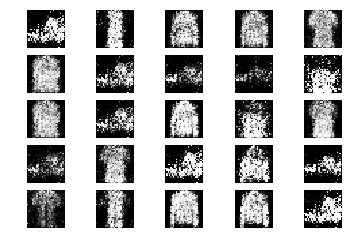

2301 [D loss: 0.722540, acc.: 48.44%] [G loss: 1.042094]
2302 [D loss: 0.634173, acc.: 65.62%] [G loss: 1.057605]
2303 [D loss: 0.671836, acc.: 59.38%] [G loss: 1.032901]
2304 [D loss: 0.640010, acc.: 56.25%] [G loss: 0.963188]
2305 [D loss: 0.704431, acc.: 51.56%] [G loss: 0.921436]
2306 [D loss: 0.712382, acc.: 50.00%] [G loss: 1.009272]
2307 [D loss: 0.631813, acc.: 65.62%] [G loss: 1.046105]
2308 [D loss: 0.674672, acc.: 54.69%] [G loss: 1.033774]
2309 [D loss: 0.618999, acc.: 60.94%] [G loss: 0.956075]
2310 [D loss: 0.674601, acc.: 56.25%] [G loss: 0.966951]
2311 [D loss: 0.647338, acc.: 54.69%] [G loss: 0.957870]
2312 [D loss: 0.665920, acc.: 57.81%] [G loss: 0.994979]
2313 [D loss: 0.609487, acc.: 67.19%] [G loss: 1.039345]
2314 [D loss: 0.623112, acc.: 73.44%] [G loss: 1.097307]
2315 [D loss: 0.582643, acc.: 78.12%] [G loss: 0.946536]
2316 [D loss: 0.641348, acc.: 67.19%] [G loss: 0.974047]
2317 [D loss: 0.595608, acc.: 67.19%] [G loss: 1.004179]
2318 [D loss: 0.626660, acc.: 6

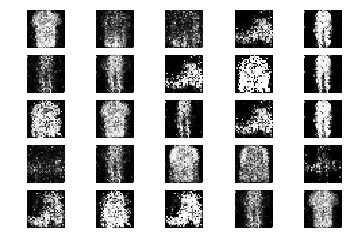

2351 [D loss: 0.664473, acc.: 65.62%] [G loss: 1.003541]
2352 [D loss: 0.632658, acc.: 65.62%] [G loss: 0.975397]
2353 [D loss: 0.723144, acc.: 59.38%] [G loss: 0.963935]
2354 [D loss: 0.703288, acc.: 57.81%] [G loss: 0.927076]
2355 [D loss: 0.631835, acc.: 60.94%] [G loss: 0.976135]
2356 [D loss: 0.606649, acc.: 71.88%] [G loss: 0.940586]
2357 [D loss: 0.616778, acc.: 70.31%] [G loss: 0.956790]
2358 [D loss: 0.623381, acc.: 70.31%] [G loss: 0.927742]
2359 [D loss: 0.624436, acc.: 62.50%] [G loss: 0.949008]
2360 [D loss: 0.673909, acc.: 60.94%] [G loss: 0.979740]
2361 [D loss: 0.667892, acc.: 53.12%] [G loss: 0.971726]
2362 [D loss: 0.644923, acc.: 59.38%] [G loss: 0.916982]
2363 [D loss: 0.679515, acc.: 54.69%] [G loss: 0.888101]
2364 [D loss: 0.632065, acc.: 57.81%] [G loss: 0.992706]
2365 [D loss: 0.678531, acc.: 62.50%] [G loss: 0.944347]
2366 [D loss: 0.712237, acc.: 56.25%] [G loss: 0.991742]
2367 [D loss: 0.663869, acc.: 57.81%] [G loss: 0.959744]
2368 [D loss: 0.729169, acc.: 3

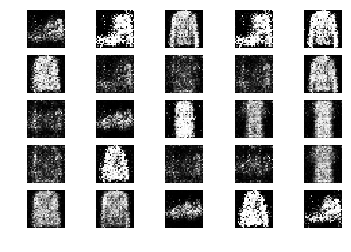

2401 [D loss: 0.646992, acc.: 59.38%] [G loss: 0.942640]
2402 [D loss: 0.631988, acc.: 64.06%] [G loss: 0.891101]
2403 [D loss: 0.689309, acc.: 51.56%] [G loss: 0.931070]
2404 [D loss: 0.673397, acc.: 54.69%] [G loss: 0.917375]
2405 [D loss: 0.666132, acc.: 59.38%] [G loss: 0.923543]
2406 [D loss: 0.632939, acc.: 60.94%] [G loss: 0.956492]
2407 [D loss: 0.674920, acc.: 59.38%] [G loss: 0.856102]
2408 [D loss: 0.676159, acc.: 60.94%] [G loss: 0.825762]
2409 [D loss: 0.713723, acc.: 60.94%] [G loss: 0.872364]
2410 [D loss: 0.656302, acc.: 65.62%] [G loss: 0.805619]
2411 [D loss: 0.687511, acc.: 51.56%] [G loss: 0.849601]
2412 [D loss: 0.728982, acc.: 40.62%] [G loss: 0.906060]
2413 [D loss: 0.641521, acc.: 65.62%] [G loss: 0.886039]
2414 [D loss: 0.706632, acc.: 42.19%] [G loss: 0.938696]
2415 [D loss: 0.729048, acc.: 42.19%] [G loss: 0.804015]
2416 [D loss: 0.598246, acc.: 68.75%] [G loss: 0.935392]
2417 [D loss: 0.650794, acc.: 70.31%] [G loss: 0.945476]
2418 [D loss: 0.635636, acc.: 6

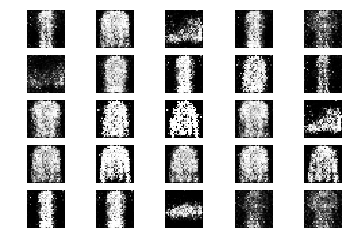

2451 [D loss: 0.610808, acc.: 71.88%] [G loss: 0.988243]
2452 [D loss: 0.658230, acc.: 62.50%] [G loss: 0.957967]
2453 [D loss: 0.640085, acc.: 65.62%] [G loss: 0.896086]
2454 [D loss: 0.612361, acc.: 71.88%] [G loss: 0.878652]
2455 [D loss: 0.702178, acc.: 60.94%] [G loss: 0.899642]
2456 [D loss: 0.649256, acc.: 57.81%] [G loss: 0.973632]
2457 [D loss: 0.597650, acc.: 76.56%] [G loss: 0.965420]
2458 [D loss: 0.631369, acc.: 59.38%] [G loss: 1.002519]
2459 [D loss: 0.630163, acc.: 64.06%] [G loss: 0.912514]
2460 [D loss: 0.680849, acc.: 60.94%] [G loss: 0.863375]
2461 [D loss: 0.734692, acc.: 46.88%] [G loss: 0.952309]
2462 [D loss: 0.584399, acc.: 68.75%] [G loss: 0.956674]
2463 [D loss: 0.794470, acc.: 43.75%] [G loss: 0.900632]
2464 [D loss: 0.692552, acc.: 59.38%] [G loss: 1.000534]
2465 [D loss: 0.713950, acc.: 54.69%] [G loss: 0.871711]
2466 [D loss: 0.593085, acc.: 62.50%] [G loss: 1.118637]
2467 [D loss: 0.601439, acc.: 70.31%] [G loss: 1.003357]
2468 [D loss: 0.715280, acc.: 5

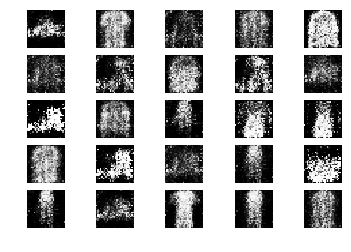

2501 [D loss: 0.649532, acc.: 57.81%] [G loss: 0.973103]
2502 [D loss: 0.655230, acc.: 54.69%] [G loss: 0.910116]
2503 [D loss: 0.657712, acc.: 59.38%] [G loss: 1.009330]
2504 [D loss: 0.708400, acc.: 57.81%] [G loss: 0.924688]
2505 [D loss: 0.722041, acc.: 53.12%] [G loss: 0.922743]
2506 [D loss: 0.638613, acc.: 76.56%] [G loss: 0.984113]
2507 [D loss: 0.703868, acc.: 51.56%] [G loss: 0.960904]
2508 [D loss: 0.754509, acc.: 48.44%] [G loss: 0.880509]
2509 [D loss: 0.659477, acc.: 64.06%] [G loss: 0.888271]
2510 [D loss: 0.696417, acc.: 59.38%] [G loss: 0.842006]
2511 [D loss: 0.652710, acc.: 60.94%] [G loss: 0.901480]
2512 [D loss: 0.687915, acc.: 65.62%] [G loss: 0.922561]
2513 [D loss: 0.685763, acc.: 57.81%] [G loss: 1.010935]
2514 [D loss: 0.683127, acc.: 65.62%] [G loss: 0.958724]
2515 [D loss: 0.713849, acc.: 56.25%] [G loss: 0.921009]
2516 [D loss: 0.710593, acc.: 48.44%] [G loss: 0.893105]
2517 [D loss: 0.701180, acc.: 51.56%] [G loss: 0.859416]
2518 [D loss: 0.711986, acc.: 5

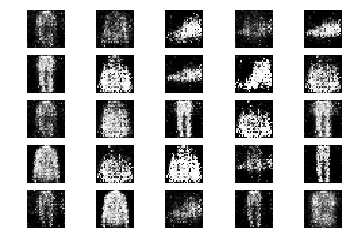

2551 [D loss: 0.723244, acc.: 50.00%] [G loss: 0.920807]
2552 [D loss: 0.685144, acc.: 51.56%] [G loss: 0.911582]
2553 [D loss: 0.571775, acc.: 71.88%] [G loss: 0.918615]
2554 [D loss: 0.673499, acc.: 62.50%] [G loss: 0.951932]
2555 [D loss: 0.649804, acc.: 59.38%] [G loss: 0.857268]
2556 [D loss: 0.637947, acc.: 67.19%] [G loss: 0.931151]
2557 [D loss: 0.674567, acc.: 62.50%] [G loss: 0.869263]
2558 [D loss: 0.642657, acc.: 60.94%] [G loss: 0.929731]
2559 [D loss: 0.693357, acc.: 48.44%] [G loss: 0.897504]
2560 [D loss: 0.636892, acc.: 64.06%] [G loss: 0.902249]
2561 [D loss: 0.701901, acc.: 59.38%] [G loss: 0.905473]
2562 [D loss: 0.636370, acc.: 56.25%] [G loss: 0.880354]
2563 [D loss: 0.695912, acc.: 48.44%] [G loss: 0.823745]
2564 [D loss: 0.651999, acc.: 57.81%] [G loss: 0.862720]
2565 [D loss: 0.689063, acc.: 64.06%] [G loss: 0.892883]
2566 [D loss: 0.624155, acc.: 67.19%] [G loss: 0.898313]
2567 [D loss: 0.666221, acc.: 54.69%] [G loss: 1.007275]
2568 [D loss: 0.642433, acc.: 6

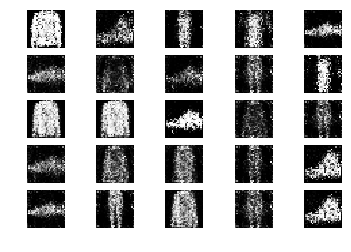

2601 [D loss: 0.675247, acc.: 57.81%] [G loss: 0.856172]
2602 [D loss: 0.719186, acc.: 53.12%] [G loss: 0.822309]
2603 [D loss: 0.732460, acc.: 50.00%] [G loss: 0.850573]
2604 [D loss: 0.636365, acc.: 62.50%] [G loss: 0.918256]
2605 [D loss: 0.699907, acc.: 48.44%] [G loss: 0.960366]
2606 [D loss: 0.612574, acc.: 56.25%] [G loss: 0.955409]
2607 [D loss: 0.696308, acc.: 51.56%] [G loss: 0.834852]
2608 [D loss: 0.728141, acc.: 43.75%] [G loss: 0.887473]
2609 [D loss: 0.617808, acc.: 70.31%] [G loss: 0.856452]
2610 [D loss: 0.638530, acc.: 65.62%] [G loss: 0.893432]
2611 [D loss: 0.705411, acc.: 48.44%] [G loss: 0.936216]
2612 [D loss: 0.672763, acc.: 53.12%] [G loss: 0.945394]
2613 [D loss: 0.648295, acc.: 60.94%] [G loss: 0.898621]
2614 [D loss: 0.666720, acc.: 50.00%] [G loss: 0.897756]
2615 [D loss: 0.661465, acc.: 60.94%] [G loss: 0.862342]
2616 [D loss: 0.660928, acc.: 64.06%] [G loss: 0.864908]
2617 [D loss: 0.667027, acc.: 57.81%] [G loss: 0.846029]
2618 [D loss: 0.650890, acc.: 5

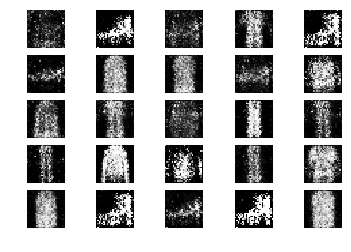

2651 [D loss: 0.664397, acc.: 57.81%] [G loss: 0.963967]
2652 [D loss: 0.661678, acc.: 56.25%] [G loss: 0.940816]
2653 [D loss: 0.592353, acc.: 70.31%] [G loss: 0.889557]
2654 [D loss: 0.659001, acc.: 64.06%] [G loss: 0.838274]
2655 [D loss: 0.688577, acc.: 60.94%] [G loss: 0.842933]
2656 [D loss: 0.622024, acc.: 67.19%] [G loss: 0.839869]
2657 [D loss: 0.605383, acc.: 70.31%] [G loss: 0.928994]
2658 [D loss: 0.625646, acc.: 67.19%] [G loss: 1.001063]
2659 [D loss: 0.562024, acc.: 68.75%] [G loss: 1.011069]
2660 [D loss: 0.648427, acc.: 64.06%] [G loss: 0.985209]
2661 [D loss: 0.643296, acc.: 62.50%] [G loss: 0.973708]
2662 [D loss: 0.650653, acc.: 62.50%] [G loss: 1.007134]
2663 [D loss: 0.708228, acc.: 59.38%] [G loss: 0.904392]
2664 [D loss: 0.688272, acc.: 54.69%] [G loss: 0.929293]
2665 [D loss: 0.723247, acc.: 51.56%] [G loss: 0.751992]
2666 [D loss: 0.698022, acc.: 48.44%] [G loss: 0.884502]
2667 [D loss: 0.695130, acc.: 57.81%] [G loss: 0.861832]
2668 [D loss: 0.713470, acc.: 5

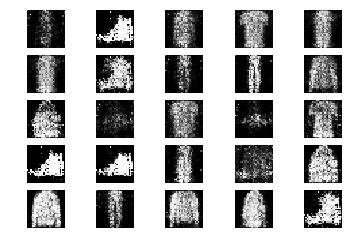

2701 [D loss: 0.661205, acc.: 62.50%] [G loss: 0.853512]
2702 [D loss: 0.668807, acc.: 56.25%] [G loss: 0.896894]
2703 [D loss: 0.655390, acc.: 64.06%] [G loss: 0.883028]
2704 [D loss: 0.675955, acc.: 54.69%] [G loss: 0.888616]
2705 [D loss: 0.696604, acc.: 64.06%] [G loss: 0.882253]
2706 [D loss: 0.726654, acc.: 50.00%] [G loss: 0.917808]
2707 [D loss: 0.668378, acc.: 60.94%] [G loss: 0.868136]
2708 [D loss: 0.669966, acc.: 62.50%] [G loss: 0.877348]
2709 [D loss: 0.711321, acc.: 56.25%] [G loss: 0.854443]
2710 [D loss: 0.683818, acc.: 50.00%] [G loss: 0.891322]
2711 [D loss: 0.664842, acc.: 56.25%] [G loss: 0.915148]
2712 [D loss: 0.717995, acc.: 54.69%] [G loss: 0.847014]
2713 [D loss: 0.727949, acc.: 51.56%] [G loss: 0.859179]
2714 [D loss: 0.715681, acc.: 48.44%] [G loss: 0.786451]
2715 [D loss: 0.646340, acc.: 67.19%] [G loss: 0.835526]
2716 [D loss: 0.679721, acc.: 57.81%] [G loss: 0.827944]
2717 [D loss: 0.725059, acc.: 50.00%] [G loss: 0.823803]
2718 [D loss: 0.670537, acc.: 6

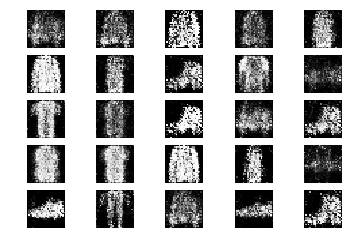

2751 [D loss: 0.733045, acc.: 50.00%] [G loss: 0.860045]
2752 [D loss: 0.686623, acc.: 54.69%] [G loss: 0.829537]
2753 [D loss: 0.667810, acc.: 51.56%] [G loss: 0.865869]
2754 [D loss: 0.651930, acc.: 57.81%] [G loss: 0.853753]
2755 [D loss: 0.592093, acc.: 68.75%] [G loss: 0.876884]
2756 [D loss: 0.724702, acc.: 45.31%] [G loss: 0.851416]
2757 [D loss: 0.712356, acc.: 42.19%] [G loss: 0.847107]
2758 [D loss: 0.691239, acc.: 50.00%] [G loss: 0.932024]
2759 [D loss: 0.688962, acc.: 53.12%] [G loss: 0.939283]
2760 [D loss: 0.693009, acc.: 56.25%] [G loss: 0.826398]
2761 [D loss: 0.677580, acc.: 43.75%] [G loss: 0.842944]
2762 [D loss: 0.712299, acc.: 48.44%] [G loss: 0.892442]
2763 [D loss: 0.620069, acc.: 64.06%] [G loss: 0.894812]
2764 [D loss: 0.631490, acc.: 60.94%] [G loss: 0.962582]
2765 [D loss: 0.682795, acc.: 54.69%] [G loss: 0.873235]
2766 [D loss: 0.698899, acc.: 53.12%] [G loss: 0.957497]
2767 [D loss: 0.672209, acc.: 56.25%] [G loss: 0.955188]
2768 [D loss: 0.718292, acc.: 5

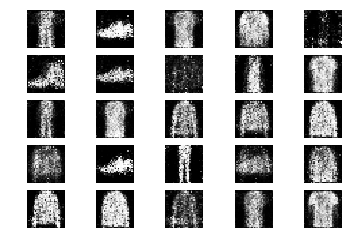

2801 [D loss: 0.731071, acc.: 46.88%] [G loss: 0.869995]
2802 [D loss: 0.671002, acc.: 56.25%] [G loss: 0.876318]
2803 [D loss: 0.618146, acc.: 62.50%] [G loss: 0.899066]
2804 [D loss: 0.637941, acc.: 60.94%] [G loss: 0.956185]
2805 [D loss: 0.651003, acc.: 67.19%] [G loss: 0.863223]
2806 [D loss: 0.698417, acc.: 51.56%] [G loss: 0.852406]
2807 [D loss: 0.662046, acc.: 64.06%] [G loss: 0.897590]
2808 [D loss: 0.692717, acc.: 54.69%] [G loss: 0.858545]
2809 [D loss: 0.632342, acc.: 67.19%] [G loss: 0.804443]
2810 [D loss: 0.800727, acc.: 46.88%] [G loss: 0.947219]
2811 [D loss: 0.678896, acc.: 48.44%] [G loss: 0.925750]
2812 [D loss: 0.716458, acc.: 45.31%] [G loss: 0.854215]
2813 [D loss: 0.669255, acc.: 57.81%] [G loss: 0.829208]
2814 [D loss: 0.681234, acc.: 56.25%] [G loss: 0.841221]
2815 [D loss: 0.681988, acc.: 54.69%] [G loss: 0.818871]
2816 [D loss: 0.713292, acc.: 51.56%] [G loss: 0.819479]
2817 [D loss: 0.685331, acc.: 53.12%] [G loss: 0.768916]
2818 [D loss: 0.679498, acc.: 5

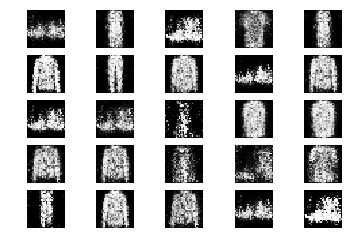

2851 [D loss: 0.654450, acc.: 50.00%] [G loss: 0.891942]
2852 [D loss: 0.691480, acc.: 53.12%] [G loss: 0.863814]
2853 [D loss: 0.643445, acc.: 65.62%] [G loss: 0.789114]
2854 [D loss: 0.623395, acc.: 62.50%] [G loss: 0.817380]
2855 [D loss: 0.689752, acc.: 53.12%] [G loss: 0.821149]
2856 [D loss: 0.679291, acc.: 53.12%] [G loss: 0.807545]
2857 [D loss: 0.663272, acc.: 57.81%] [G loss: 0.854108]
2858 [D loss: 0.595311, acc.: 67.19%] [G loss: 0.906864]
2859 [D loss: 0.658541, acc.: 60.94%] [G loss: 0.908059]
2860 [D loss: 0.648592, acc.: 67.19%] [G loss: 0.827297]
2861 [D loss: 0.738221, acc.: 56.25%] [G loss: 0.843000]
2862 [D loss: 0.650666, acc.: 59.38%] [G loss: 0.760680]
2863 [D loss: 0.700265, acc.: 53.12%] [G loss: 0.810032]
2864 [D loss: 0.731879, acc.: 42.19%] [G loss: 0.884983]
2865 [D loss: 0.593183, acc.: 73.44%] [G loss: 0.810209]
2866 [D loss: 0.674384, acc.: 48.44%] [G loss: 0.842201]
2867 [D loss: 0.673482, acc.: 65.62%] [G loss: 0.813944]
2868 [D loss: 0.731073, acc.: 5

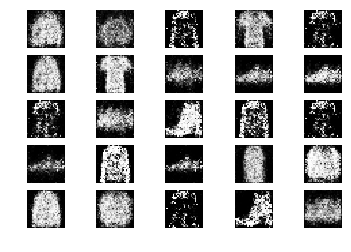

2901 [D loss: 0.638590, acc.: 64.06%] [G loss: 0.910659]
2902 [D loss: 0.659238, acc.: 59.38%] [G loss: 0.875943]
2903 [D loss: 0.667554, acc.: 60.94%] [G loss: 1.031823]
2904 [D loss: 0.650787, acc.: 70.31%] [G loss: 0.889087]
2905 [D loss: 0.704101, acc.: 50.00%] [G loss: 0.884690]
2906 [D loss: 0.659761, acc.: 59.38%] [G loss: 0.862498]
2907 [D loss: 0.696338, acc.: 53.12%] [G loss: 0.838848]
2908 [D loss: 0.677487, acc.: 50.00%] [G loss: 0.812615]
2909 [D loss: 0.619633, acc.: 60.94%] [G loss: 0.821230]
2910 [D loss: 0.653347, acc.: 57.81%] [G loss: 0.822094]
2911 [D loss: 0.747141, acc.: 53.12%] [G loss: 0.842920]
2912 [D loss: 0.681053, acc.: 54.69%] [G loss: 0.840704]
2913 [D loss: 0.681833, acc.: 62.50%] [G loss: 0.888014]
2914 [D loss: 0.631057, acc.: 65.62%] [G loss: 0.823063]
2915 [D loss: 0.785559, acc.: 45.31%] [G loss: 0.781885]
2916 [D loss: 0.725765, acc.: 45.31%] [G loss: 0.881795]
2917 [D loss: 0.683766, acc.: 57.81%] [G loss: 0.874001]
2918 [D loss: 0.658637, acc.: 6

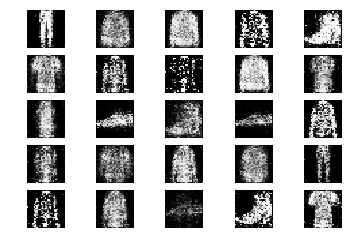

2951 [D loss: 0.674020, acc.: 59.38%] [G loss: 0.816500]
2952 [D loss: 0.644755, acc.: 59.38%] [G loss: 0.869853]
2953 [D loss: 0.651792, acc.: 60.94%] [G loss: 0.832241]
2954 [D loss: 0.685683, acc.: 53.12%] [G loss: 0.753704]
2955 [D loss: 0.668850, acc.: 57.81%] [G loss: 0.787393]
2956 [D loss: 0.698444, acc.: 53.12%] [G loss: 0.890115]
2957 [D loss: 0.707556, acc.: 50.00%] [G loss: 0.904979]
2958 [D loss: 0.577255, acc.: 73.44%] [G loss: 0.873560]
2959 [D loss: 0.703360, acc.: 53.12%] [G loss: 0.832647]
2960 [D loss: 0.636158, acc.: 67.19%] [G loss: 0.791979]
2961 [D loss: 0.642539, acc.: 53.12%] [G loss: 0.897954]
2962 [D loss: 0.695692, acc.: 60.94%] [G loss: 0.791779]
2963 [D loss: 0.668366, acc.: 57.81%] [G loss: 0.817915]
2964 [D loss: 0.659347, acc.: 75.00%] [G loss: 0.897749]
2965 [D loss: 0.623077, acc.: 62.50%] [G loss: 0.905255]
2966 [D loss: 0.729502, acc.: 57.81%] [G loss: 0.822131]
2967 [D loss: 0.590788, acc.: 65.62%] [G loss: 0.879356]
2968 [D loss: 0.579473, acc.: 7

In [75]:
epochs = 3000

batch_size = 32
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
  # Train discriminator
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]

  noise = np.random.normal(0, 1, (batch_size, 100))

  gen_imgs = generator.predict(noise)

  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

  # Train generator
  noise = np.random.normal(0, 1, (batch_size, 100))

  g_loss = combined.train_on_batch(noise, valid)

  print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

  if epoch % 50 == 0:
    sample_images(epoch)

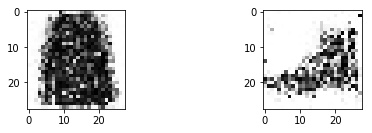

In [87]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r*c, 100))
gen_imgs = generator.predict(noise)

gen_imgs = 0.5*gen_imgs+0.5

plt.figure(figsize=(6, 3))
plt.subplot(131)
plt.imshow(gen_imgs[0, :, :, 0], cmap='Greys')
plt.subplot(133)
plt.imshow(gen_imgs[1, :, :, 0], cmap='Greys')
plt.show()
plt.close()
